Cyna Shirazinejad, 7/7/21

# Notebook 12: measure random ARPC3+ "recruitment" and test alternative CCP-selection models

outline:
* shuffle AP2 and ARPC3 channel pairs between movies and measure ARPC3+ percentages
* test ARPC3+ percentages for alternative CCP-selection models with variable DNM2+ peak requirements

##### import all necessary Python modules

In [76]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle
from IPython.display import Image
from tqdm import tqdm
import warnings
import random
from scipy import signal

%matplotlib inline
unique_user_path_notebook = str(np.load('unique_user_path_notebook.npy'))
unique_user_saved_outputs = str(np.load('unique_user_saved_outputs.npy'))
unique_user_saved_tracks = str(np.load('unique_user_path_tracks.npy'))
sys.path.append(unique_user_path_notebook+'/cmeAnalysisPostProcessingPythonScripts') # add custom Python scripts to the local path
import merge_tools
import generate_index_dictionary
import return_track_attributes
import display_tracks
index_dictionary = generate_index_dictionary.return_index_dictionary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# load dataframe from notebook 3 containing normal-pdf scaled features: PC's and GMM predicted clusters, and dataframe with cmeAnalysis labels

In [77]:
df_pcs_normal_scaled_with_gmm_cluster = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_new_incorporated_data_pcs_gmm_clusters.zip')
df_merged_features = pd.read_csv(unique_user_saved_outputs+'/dataframes/df_new_incorporated_data_merged_features.zip')
index_dnm2positive = np.load(unique_user_saved_outputs+'/dataframes/cluster_dnm2_positive.npy')
number_of_track_splits = np.load(unique_user_saved_outputs+'/dataframes/number_of_track_splits.npy')
number_of_clusters = np.load(unique_user_saved_outputs+"/dataframes/number_of_clusters.npy")
ccp_predictions = np.load(unique_user_saved_outputs+'/dataframes/merged_ccp_predictions.npy')

In [78]:
best_fit_peak_params = np.load(unique_user_saved_outputs+'/dataframes/parameters_best_fit_peak_finding.npy')
sos = signal.butter(4, 0.2, 'lp', fs=1, output='sos')

In [79]:
df_merged_features

lifetime  max_int_ap2  max_int_dnm2  dist_traveled_ap2  \
0          216.0  1796.284550    740.516756           7.203812   
1          201.0  2215.532695   1505.433273          17.220726   
2          201.0   864.976087    421.405691          17.621866   
3          192.0   509.795166    356.302521          10.804211   
4          188.0  1636.422386    883.606436          11.255090   
...          ...          ...           ...                ...   
154359       2.0    71.707995     35.951988           5.059682   
154360       2.0    25.338391     38.053364           2.261592   
154361       2.0   207.539790    166.846303           2.391855   
154362       2.0    16.610995     36.530651           3.546351   
154363       2.0    23.581859     13.059217           1.518990   

        dist_traveled_dnm2  max_dist_between_ap2_dnm2    md_ap2   md_dnm2  \
0                 7.203812                   2.630656  0.566262  0.725913   
1                14.507135                   3.797526  0.424574  0.912671   
2                17.130473                   3.472332  0.566588  0.776404   
3                13.292842                   5.888569  0.428736  1.058177   
4                 7.793074                   5.531006  0.415792  0.753372   
...                    ...                        ...       ...       ...   
154359            5.014421                   2.181787  0.766658  1.257316   
154360            2.067468                   4.632292  1.427061  1.486410   
154361            2.634261                   4.270496  1.536834  1.356576   
154362            2.761683                   3.700703  1.630578  1.907946   
154363            2.995973                   3.112202  1.728259  1.009058   

        time_to_peak_ap2  time_to_peak_dnm2  ...  kurtosis_dnm2  \
0                  159.0              186.0  ...       0.889904   
1                  111.0              107.0  ...       8.009901   
2                   42.0               44.0  ...       0.807456   
3                   44.0              190.0  ...       4.081995   
4                  174.0              169.0  ...       2.885473   
...                  ...                ...  ...            ...   
154359               5.0                4.0  ...       0.652187   
154360               6.0                2.0  ...      -0.519547   
154361               5.0                0.0  ...      -0.467286   
154362               5.0                9.0  ...      -1.330293   
154363               6.0                0.0  ...      -0.889286   

        number_significant_dnm2  max_consecutive_significant_dnm2  \
0                         167.0                              43.0   
1                         115.0                              89.0   
2                         167.0                              70.0   
3                         112.0                              57.0   
4                         169.0                              80.0   
...                         ...                               ...   
154359                      0.0                               0.0   
154360                      7.0                               3.0   
154361                      5.0                               3.0   
154362                      2.0                               1.0   
154363                      0.0                               0.0   

        fraction_significant_dnm2  fraction_peak_ap2  fraction_peak_dnm2  \
0                        0.738938           0.703540            0.823009   
1                        0.545024           0.526066            0.507109   
2                        0.791469           0.199052            0.208531   
3                        0.554455           0.217822            0.940594   
4                        0.853535           0.878788            0.853535   
...                           ...                ...                 ...   
154359                   0.000000           0.416667            0.333333   
154360                   0.583333           0.50

# load all valid arpc3 tracks

In [80]:
valid_tracks_arpc3 = [np.load(unique_user_saved_outputs+'/dataframes/valid_arpc3_tracks_0.npy', allow_pickle=True)]

for i in range(1,13):
    
    valid_tracks_arpc3 += [np.load(unique_user_saved_outputs+'/dataframes/valid_arpc3_tracks_'+str(i)+'.npy', allow_pickle=True)]

In [81]:
merged_valid_tracks_arpc3 = merge_tools.merge_experiments(valid_tracks_arpc3,[list(range(len(track_set))) for track_set in valid_tracks_arpc3])

# load all valid tracks

In [82]:
merged_all_valid_tracks = np.load(unique_user_saved_outputs+'/dataframes/all_experiments_merged_all_valid_tracks_0.npy', allow_pickle=True)

for i in range(1, number_of_track_splits):

    merged_all_valid_tracks = np.concatenate((merged_all_valid_tracks,
                                              np.load(unique_user_saved_outputs+'/dataframes/all_experiments_merged_all_valid_tracks_'+str(i)+'.npy', allow_pickle=True)))

In [83]:
merged_all_valid_tracks.shape

(154364,)

# sort DNM2+ events

In [84]:
num_gmm_clusters = number_of_clusters # optimal number of clusters of PCA data


gmm_classes = []

for i in range(num_gmm_clusters):

    gmm_classes.append(df_pcs_normal_scaled_with_gmm_cluster[df_pcs_normal_scaled_with_gmm_cluster['gmm_predictions']==i].index.values)    

In [85]:
len(gmm_classes[index_dnm2positive])

13797

In [86]:
tracks_authentic_ccps_gmm = merged_all_valid_tracks[gmm_classes[index_dnm2positive]] #dnm2 positive events, mixed CCPS and hot-spots

In [87]:
len(tracks_authentic_ccps_gmm)

13797

# isolate hot-spot and individual CCP mixed authentic CCP class from gmm

In [88]:
experiment_number_track_candidates = df_merged_features['experiment_number'][gmm_classes[index_dnm2positive]] # experiment numbers (1-16)

In [89]:
len(experiment_number_track_candidates)

13797

# separate single-CCP events by experiment

In [90]:
merged_all_valid_tracks_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted ccps 
hotspot_events_per_experiment = [] # each entry is a list for each experiment of tracks corresponding to predicted hot-spots 
ccp_events_per_experiment = []

for experiment_number in range(8, 21): # only look at 3-color movies
    
    current_exp_ind = np.where(experiment_number_track_candidates==experiment_number)[0] # all events in current experiment
    hotspot_pred_exp = ccp_predictions[current_exp_ind] # hot-spot predictions for current experiment
    tracks_exp = tracks_authentic_ccps_gmm[current_exp_ind] # all tracks in current experiment
    
    non_hotspot_ind = np.where(hotspot_pred_exp==1)[0] # single ccp event indices
    tracks_single_ccp_exp = tracks_exp[non_hotspot_ind] # single ccp tracks
    ccp_events_per_experiment.append(tracks_single_ccp_exp)

<!-- # measure ap2 initiation to dnm2 peak lifetime, comparing 2 cell lines -->

# merge all CCPs

In [91]:
merged_ccps = merge_tools.merge_experiments(ccp_events_per_experiment, [list(range(len(track_set))) for track_set in ccp_events_per_experiment])

In [92]:
len(merged_ccps)

3302

# reload (or load) trees 

In [93]:
arpc3_trees = []

for i in range(8,21):
    
    with open(unique_user_saved_outputs+'/dataframes/arpc3_kdtree_'+str(i), 'rb') as f:
        tree = pickle.load(f)
        
    index_matrix = np.load(unique_user_saved_outputs+"/dataframes/arpc3_tree_index_matrix_"+str(i)+'.npy', allow_pickle=True)

    arpc3_trees.append([tree, index_matrix])

# check ARPC3+ fraction for randomized/shuffled experiments (non-matching AP2/DNM2 and ARPC3 tracking)

In [94]:
warnings.filterwarnings("ignore")
distance_query = 2 # pixel search radius for associating ap2 and arpc3 from separate tracking

fraction_arpc3_positive_mixed = []
experiment_combos = []
num_frames_associated_randomized = []
ap2_arpc3_separation_average_arpc3_positive_randomized = []
arpc3_lifetime_randomized = []
dnm2_arpc3_peak_time_difference_arpc3_positive_randomized = []


ch0_vectors_arpc3_positive = [] # amplitudes of ARPC3+ negative events
ch1_vectors_arpc3_positive = [] #
ch2_vectors_arpc3_positive = [] #

# arpc3 negative events
ch0_vectors_arpc3_negative = []
ch1_vectors_arpc3_negative = []

significant_arpc3_at_dnm2_peak_arpc3_positive_randomized = []

num_no_neighbors=0

for i in tqdm(range(250)):  # iterate over 1000 random samples

    
    num_with_mode = 0 # count number of events with and without arpc3
    num_without_mode = 0    

    possible_exp = list(range(13))
    
    ap2_index = random.choice(possible_exp)
    
    possible_exp.pop(ap2_index)
    
    arpc3_index = random.choice(possible_exp)
    
    ap2dmn2_tracks_in_experiment = ccp_events_per_experiment[ap2_index] # filtered tracks
    arpc3_experiment=valid_tracks_arpc3[arpc3_index] # cat 1 and 2 arpc3 events in experiment


    experiment_combos.append([ap2_index, arpc3_index])
    # select a tree for each frame containing all events in each frame
    kd_tree_arpc3_experiment, vals_tree = arpc3_trees[arpc3_index]
        
    for track_num in range(len(ap2dmn2_tracks_in_experiment)): # iterate through all ap2 tracks in experiment

        
        frames_in_track_first_channel = list(return_track_attributes.return_frames_in_track_no_buffer(ap2dmn2_tracks_in_experiment, track_num)-1) # frames of ap2 and dnm2
        ch0_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # positions of ap2 and dnm2
        ch0_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0)
        ch1_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        ch1_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        ap2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # ap2 and dnm2 intensities
        dnm2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
        filtered_dnm2_signal = list(list(signal.sosfilt(sos, dnm2_int)) + [0, 0, 0, 0, 0])
    
        dnm2_peak = signal.find_peaks(filtered_dnm2_signal, 
                                      distance=best_fit_peak_params[0], 
                                      height=best_fit_peak_params[1],
                                      width=best_fit_peak_params[2])[0][0]
        
        frame_dnm2_peak = frames_in_track_first_channel[dnm2_peak] # the movie frame (indexed starting from 0) that dnm2 peaks   
        candidate_arpc3_neighbors = [] # indices of arpc3 events that take place near ap2
        no_neighbors=True # no neighbors found yet
        
        # search for candidate arpc3 neighbors in each ap2 track's frame
        for frame in frames_in_track_first_channel:
            
            frame_ch0 = frames_in_track_first_channel.index(frame)
            # frame's tree
            current_tree = kd_tree_arpc3_experiment[frame]
            
            # ap2 fitted position at current frame
            current_ap2_position = np.array([ch0_x[frame_ch0], ch0_y[frame_ch0]]).reshape(1, -1)
            
            # indices of arpc3 events within the query radius
            ind = current_tree.query_radius(current_ap2_position,
                                            r=distance_query)

            if len(ind[0])>0:
                no_neighbors = False # if there is a neighbor
                
            # check if each arpc3 neighbor originated before or after the ap2 event
            for candidate in ind[0]:

                candidate_index = int(vals_tree[frame][candidate][0]) # get the index of the arpc3 event
                
                frames_in_track_candidate_neighbor = list(return_track_attributes.return_frames_in_track_no_buffer(arpc3_experiment, candidate_index)-1)
                
                # consider the arpc3 event if it originated after the ap2 event and before the dnm2 peak
                if frames_in_track_candidate_neighbor[0]>frames_in_track_first_channel[0] and frames_in_track_candidate_neighbor[0]<frame_dnm2_peak:

                    candidate_arpc3_neighbors.append(candidate_index)
        
            
        if no_neighbors==True: # if there are absolutely no neighbors present, the CCP is arpc3 negative
            
            num_no_neighbors+=1
            
        # get mode(s) of candidates
        mode=stats.mode(candidate_arpc3_neighbors)
        
        # if there is a unique candidate:
        if mode[0].size == 1:
            
            num_frames_associated_randomized.append(mode[1][0])
            pval_arpc3_detection = []
            num_with_mode+=1 # count this track as arpc3 positive            
        
            associated_track_second_channel = mode[0][0] # index of arpc3 track associated with current ap2 track
            
            frames_in_track_second_channel = list(return_track_attributes.return_frames_in_track_no_buffer(arpc3_experiment, associated_track_second_channel)-1) # frames of arpc3 track
            
            frames_intersection = list(set(frames_in_track_first_channel) & set(frames_in_track_second_channel)) # find all frames ap2 and arpc3 overlap during movie
            frames_intersection.sort() # sort the frames in ascending order

            # amplitudes of all channels
            ch0_amplitudes = ap2_int # ap2, dnm2, arpc3 intensities
            ch1_amplitudes = dnm2_int
            ch2_amplitudes = return_track_attributes.return_track_amplitude_no_buffer_channel(arpc3_experiment, associated_track_second_channel, 0)

            arpc3_lifetime_randomized.append(len(ch2_amplitudes))
            
            # position of arpc3
            ch2_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(arpc3_experiment, associated_track_second_channel, 0)
            ch2_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(arpc3_experiment, associated_track_second_channel, 0)

            # correct intensities and positions for missing frames where ap2 and arpc3 are non-overlapping
            new_ch0_vector = []
            new_ch1_vector = []
            new_ch2_vector = []
            new_ch0_x = []
            new_ch0_y = []
            new_ch1_x = []
            new_ch1_y = []
            new_ch2_x = []
            new_ch2_y = []
            
            # first/last frame either ap2 or arpc3 shows up
            min_frame = np.nanmin([np.nanmin(frames_in_track_first_channel),np.nanmin(frames_in_track_second_channel)]) #nan to account for gaps
            max_frame = np.nanmax([np.nanmax(frames_in_track_first_channel),np.nanmax(frames_in_track_second_channel)])

            # all frames shared between ap2 and arpc3
            frames_all = [i for i in range(int(min_frame),int(max_frame)+1)]

            channel_0_2_separation_track = [] # ap2 and arpc3 separation
            channel_0_2_angle_track = [] # ap2 and arpc3 angle 
            channel_0_1_separation_track = [] # ap2 and dnm2 separation
            channel_1_2_separation_track = []

            for frame in frames_all: # iterate over all frames

                # if frames of ap2 and arpc3 are non-overlapping, do not measure their separation
                if (frame in frames_in_track_first_channel and frame not in frames_in_track_second_channel) or (frame in frames_in_track_second_channel and frame not in frames_in_track_first_channel):
                    channel_0_2_separation_track.append(0)
                    channel_0_2_angle_track.append(0)
                    channel_1_2_separation_track.append(0)
                # if only ap2 is present
                if frame in frames_in_track_first_channel and frame not in frames_in_track_second_channel:
                    
                    channel_0_index = frames_in_track_first_channel.index(frame) # get relative index of ap2 in this frame 

                    new_ch0_vector.append(ch0_amplitudes[channel_0_index]) # add ap2 and dnm2 amplitudes
                    new_ch1_vector.append(ch1_amplitudes[channel_0_index]) 
                    new_ch0_x.append(ch0_x[channel_0_index]) # ap2 and dnm2 positions
                    new_ch0_y.append(ch0_y[channel_0_index])
                    new_ch1_x.append(ch1_x[channel_0_index])
                    new_ch1_y.append(ch1_y[channel_0_index])

                    new_ch2_vector.append(0) # no arpc3
                    new_ch2_x.append(0) # arpc3 position off grid
                    new_ch2_y.append(0)
                    pval_arpc3_detection.append(np.NaN)
                    
                    channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch1_x[channel_0_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch1_y[channel_0_index]))**2)) # ap2-dnm2 separation

                # if only arpc3 is present
                elif frame in frames_in_track_second_channel and frame not in frames_in_track_first_channel: 

                    channel_2_index = frames_in_track_second_channel.index(frame) # get relative index of arpc3 in this frame 

                    new_ch2_vector.append(ch2_amplitudes[channel_2_index]) # add arpc3 amplitudes and positions
                    new_ch2_x.append(ch2_x[channel_2_index]) 
                    new_ch2_y.append(ch2_y[channel_2_index])
                    
                    new_ch0_vector.append(0) # no ap2 or dnm2
                    new_ch1_vector.append(0)    
                    new_ch0_x.append(0) # ap2 and dnm2 position off grid
                    new_ch0_y.append(0)
                    new_ch1_x.append(0)
                    new_ch1_y.append(0)
           
                    channel_0_1_separation_track.append(0) # no separation between ap2 and dnm2 
                    
                    pval_arpc3_detection.append(return_track_attributes.return_pvals_detection_no_buffer(arpc3_experiment, associated_track_second_channel, 0)[channel_2_index])
                
                # if both ap2 and arpc3 in frame
                elif frame in frames_in_track_first_channel and frame in frames_in_track_second_channel:  

                    channel_0_index = frames_in_track_first_channel.index(frame) # get relative indices
                    channel_2_index = frames_in_track_second_channel.index(frame)

                    new_ch0_vector.append(ch0_amplitudes[channel_0_index]) # add amplitudes and positionsfor all channels
                    new_ch1_vector.append(ch1_amplitudes[channel_0_index])
                    new_ch2_vector.append(ch2_amplitudes[channel_2_index])
                    new_ch0_x.append(ch0_x[channel_0_index]) # ap2 and dnm2 positions
                    new_ch0_y.append(ch0_y[channel_0_index])
                    new_ch1_x.append(ch1_x[channel_0_index])
                    new_ch1_y.append(ch1_y[channel_0_index])
                    new_ch2_x.append(ch2_x[channel_2_index]) 
                    new_ch2_y.append(ch2_y[channel_2_index])

                    channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch1_x[channel_0_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch1_y[channel_0_index]))**2)) # ap2-dnm2 separation
                    
                    # ap2 and arpc3 separation
                    channel_0_2_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch2_x[channel_2_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch2_y[channel_2_index]))**2))
#                     channel_0_2_angle_track.append(angle_between((0,0),((ch0_x[channel_0_index]-ch2_x[channel_2_index]),(ch0_y[channel_0_index]-ch2_y[channel_2_index]))))              
                    channel_1_2_separation_track.append(np.sqrt((0.108*(ch1_x[channel_0_index]-ch2_x[channel_2_index]))**2 + (0.108*(ch1_y[channel_0_index]-ch2_y[channel_2_index]))**2))

                    pval_arpc3_detection.append(return_track_attributes.return_pvals_detection_no_buffer(arpc3_experiment,associated_track_second_channel,0)[channel_2_index])
            
            ap2_arpc3_separation_average_arpc3_positive_randomized.append(np.nanmean(channel_0_2_separation_track))
            dnm2_arpc3_peak_time_difference_arpc3_positive_randomized.append(np.nanargmax(ch1_amplitudes)-np.nanargmax(ch2_amplitudes))
            ch0_vectors_arpc3_positive.append(new_ch0_vector)
            ch1_vectors_arpc3_positive.append(new_ch1_vector)
            ch2_vectors_arpc3_positive.append(new_ch2_vector)
                        
            if pval_arpc3_detection[np.nanargmax(new_ch1_vector)]<0.01 and pval_arpc3_detection[np.nanargmax(new_ch1_vector)] != np.NaN:
            
                significant_arpc3_at_dnm2_peak_arpc3_positive_randomized.append(1)
            
            else:
                
                significant_arpc3_at_dnm2_peak_arpc3_positive_randomized.append(0)
                
        elif no_neighbors==True: # if there is no mode then the event is arpc3 negative

            num_without_mode += 1 
            ch0_vectors_arpc3_negative.append(ap2_int)
            ch1_vectors_arpc3_negative.append(dnm2_int)
            
    fraction_arpc3_positive_mixed.append(num_with_mode/(num_with_mode+num_without_mode))   

100%|██████████| 250/250 [13:43<00:00,  3.30s/it]


# save all results

In [95]:
arrays_to_save = ['ch0_vectors_arpc3_positive',
                  'ch1_vectors_arpc3_positive',
                  'ch2_vectors_arpc3_positive',
                  'ch0_vectors_arpc3_negative',
                  'ch1_vectors_arpc3_negative',
                  'ap2_arpc3_separation_average_arpc3_positive_randomized',
                  'dnm2_arpc3_peak_time_difference_arpc3_positive_randomized',
                  'significant_arpc3_at_dnm2_peak_arpc3_positive_randomized',
                  'arpc3_lifetime_randomized',
                  'fraction_arpc3_positive_mixed',
                  'num_frames_associated_randomized']

merged_results = {}
for array in arrays_to_save:
    
    merged_results[array] = locals()[array]   

In [96]:
with open(unique_user_saved_outputs+'/dataframes/merged_ap2arpc3_data_zeropadding_randomized_experiments', 'wb') as f:
    pickle.dump(merged_results, f)   

In [97]:
with open(unique_user_saved_outputs+'/dataframes/merged_ap2arpc3_data_zeropadding_randomized_experiments', 'rb') as f:
    merged_results = pickle.load(f)  


In [98]:
merged_results_randomized = merged_results

In [99]:
channel_amplitudes_arpc3_negative = []
for i in range(len(merged_results['ch0_vectors_arpc3_negative'])):
    channel_amplitudes_arpc3_negative.append([merged_results['ch0_vectors_arpc3_negative'][i],
                                              merged_results['ch1_vectors_arpc3_negative'][i]])
    
channel_amplitudes_arpc3_positive = []
for i in range(len(merged_results['ch0_vectors_arpc3_positive'])):
    channel_amplitudes_arpc3_positive.append([merged_results['ch0_vectors_arpc3_positive'][i],
                                              merged_results['ch1_vectors_arpc3_positive'][i],
                                              merged_results['ch2_vectors_arpc3_positive'][i]])

In [100]:
lifetime_arpc3_negative = []
for i in range(len(channel_amplitudes_arpc3_negative)):
    lifetime_arpc3_negative.append(len(channel_amplitudes_arpc3_negative[i][0]))

lifetime_arpc3_positive = []
for i in range(len(channel_amplitudes_arpc3_positive)):
    lifetime_arpc3_positive.append(len(channel_amplitudes_arpc3_positive[i][0]))

In [101]:
%%capture

plt.style.use('default')

fig, axes = plt.subplots(1, 1, dpi=500, figsize=(15,5))

cohorts = [[min(lifetime_arpc3_negative),40],[40,60],[60,80],[80,max(lifetime_arpc3_negative)]]

offsets, num_in_cohort, max_dnm2_cohort_indices = display_tracks.plot_separated_cohorts([axes], 
                                                                         channel_amplitudes_arpc3_negative[:-1], 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1], 
                                                                         [], 
                                                                         ['AP2', 'DNM2'],
                                                                         ['m', 'g'])

lines_0, labels_0 = axes.get_legend_handles_labels()
axes.legend(lines_0, labels_0, 
            loc='upper center', 
            bbox_to_anchor=(0.88, 0.8), 
            title="{:,}".format(len(channel_amplitudes_arpc3_negative)) + ' total events')

y_lines = np.arange(0,600,100)

for i in range(1,len(y_lines)):
    
    axes.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

text_horizontal_shifts = 3
text_percentage_y = 460
text_bounds_y = 480

for i in range(len(cohorts)):

    if i==0:
        axes.text(text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_negative)) + '%')
    elif i==len(cohorts)-1:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime >}$'+str(cohorts[i][0])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_negative)) + '%')
    else:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, str(cohorts[i][0])+'$\mathregular{s \leq lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_negative)) + '%')
        
x_positions_ticks = []
x_labels_ticks = []
max_ticks_per_cohort = [[1, 1], [2, 2], [3, 3], [6, 3]]

for i in range(len(max_dnm2_cohort_indices)):
    

    num_ticks_before = np.min((int(np.floor((max_dnm2_cohort_indices[i])/10)),max_ticks_per_cohort[i][0]))
    num_ticks_after = np.min((int(np.ceil((cohorts[i][1]-max_dnm2_cohort_indices[i])/10)-1),max_ticks_per_cohort[i][1]))
    for j in range(num_ticks_before):
        
        x_labels_ticks.append(-10*(j+1))
        x_positions_ticks.append(-10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])
    
    x_labels_ticks.append(0)
    x_positions_ticks.append(offsets[i] + max_dnm2_cohort_indices[i])
    
    for j in range(num_ticks_after):
        
        x_labels_ticks.append(10*(j+1))
        x_positions_ticks.append(10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])


axes.set_xticks(0.5+np.array(x_positions_ticks), minor=False)
axes.set_xticklabels(x_labels_ticks, minor=False)


axes.set_xlabel('time (s)') 
axes.set_ylabel('a.u. fluorescence')
axes.set_title('ARPC3- CCPs, aligned to DNM2 peaks, binned in cohorts by AP2 lifetimes')
axes.set_xlim([0,offsets[-1]+cohorts[-1][-1]])    
axes.set_ylim([0,600])  
plt.tight_layout()   
plt.savefig(unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_arpc3minusccps_cohorts_centered_zero_zeropadding_randomized.png')

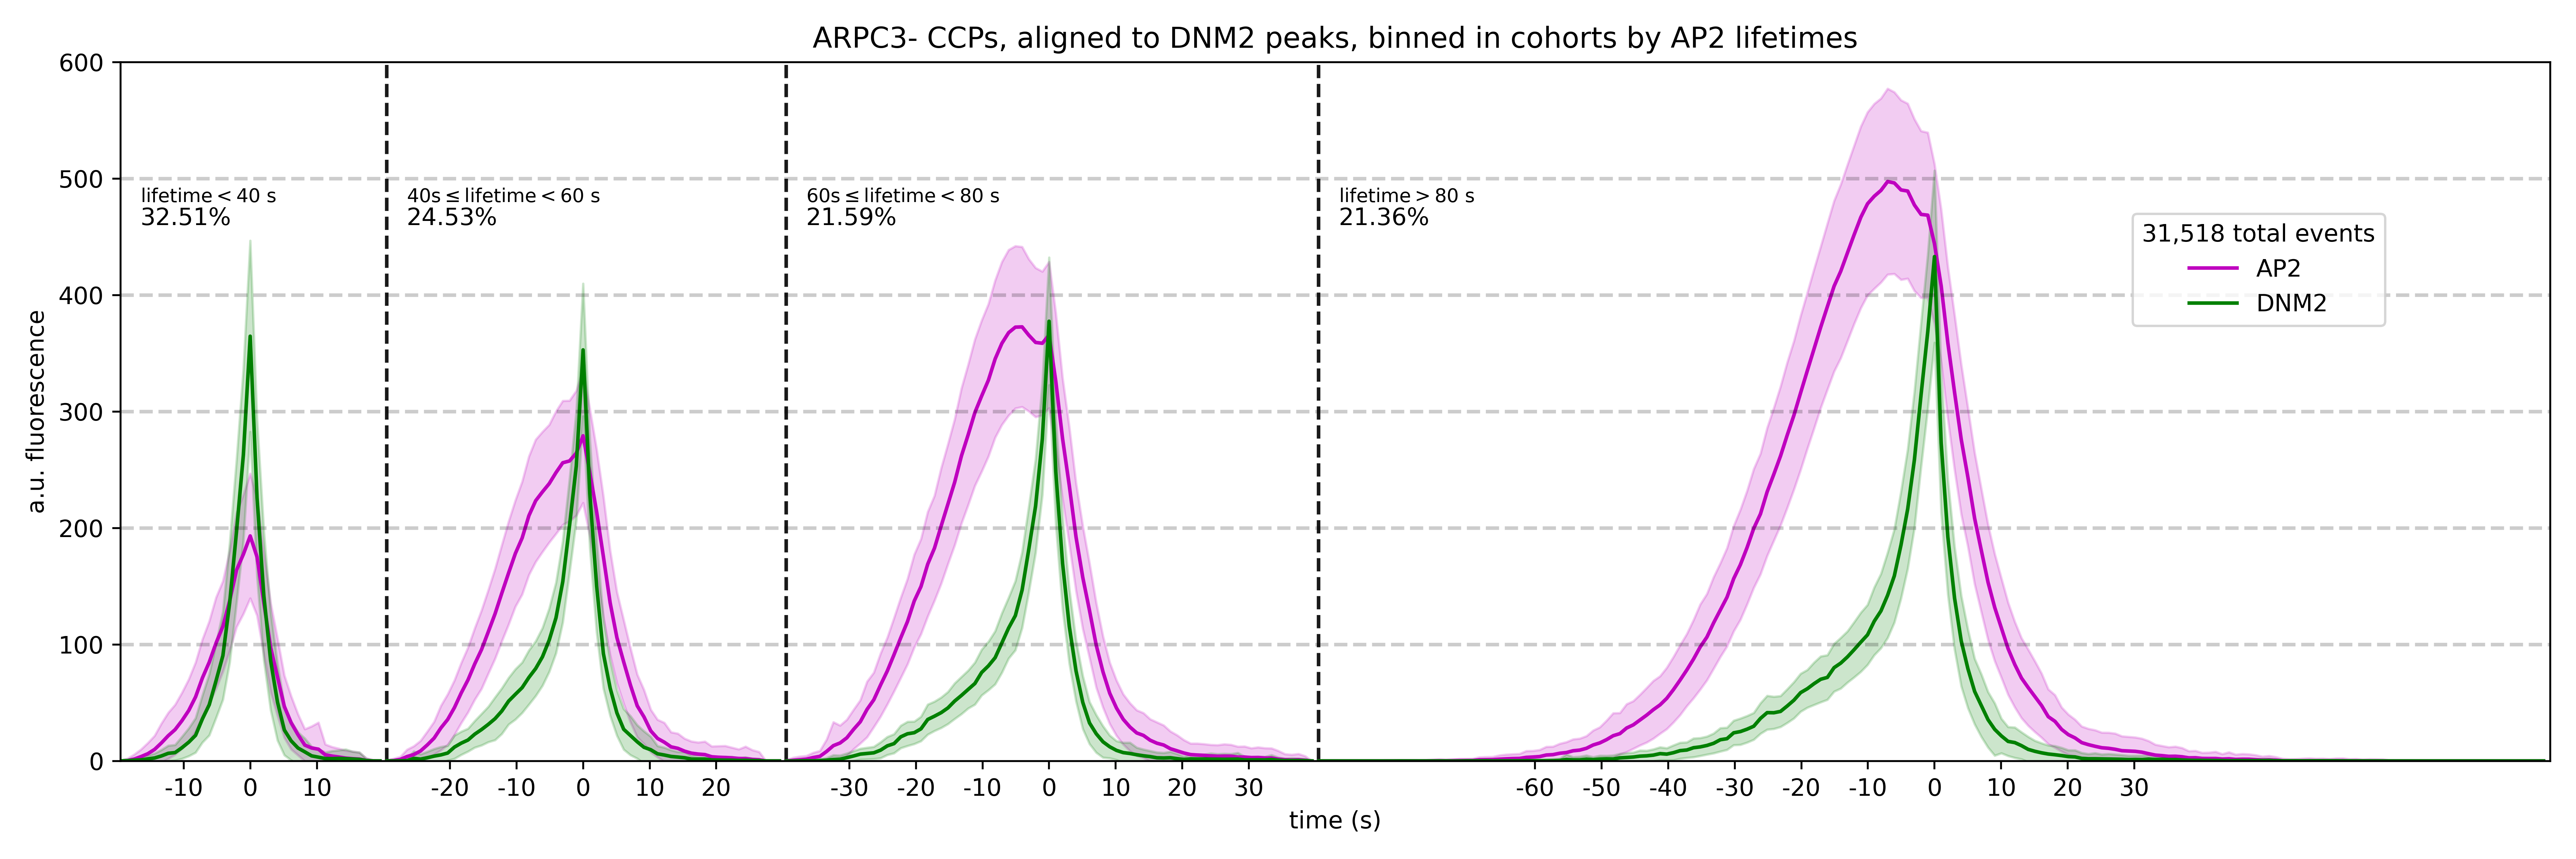

In [102]:
Image(filename=unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_arpc3minusccps_cohorts_centered_zero_zeropadding_randomized.png', height=500, width=500)

In [103]:
%%capture

plt.style.use('default')

fig, axes = plt.subplots(1, 1, dpi=500, figsize=(15,5))
# axes_separation = axes.twinx()

cohorts = [[min(lifetime_arpc3_positive),40],[40,60],[60,80],[80,max(lifetime_arpc3_positive)]]

offsets, num_in_cohort, max_dnm2_cohort_indices = display_tracks.plot_separated_cohorts([axes], 
                                                                         channel_amplitudes_arpc3_positive, 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1, 2], 
                                                                         [], 
                                                                         ['AP2', 'DNM2', 'ARPC3'],
                                                                         ['m', 'g', 'b'])

lines_0, labels_0 = axes.get_legend_handles_labels()
axes.legend(lines_0, labels_0, 
            loc='upper center', 
            bbox_to_anchor=(0.88, 0.8), 
            title="{:,}".format(len(channel_amplitudes_arpc3_positive)) + ' total events')

y_lines = np.arange(0,600,100)

for i in range(1,len(y_lines)):
    
    axes.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

text_horizontal_shifts = 3
text_percentage_y = 540
text_bounds_y = 560

for i in range(len(cohorts)):

    if i==0:
        axes.text(text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive)) + '%')
    elif i==len(cohorts)-1:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime >}$'+str(cohorts[i][0])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive)) + '%')
    else:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, str(cohorts[i][0])+'$\mathregular{s \leq lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive)) + '%')
        
x_positions_ticks = []
x_labels_ticks = []
max_ticks_per_cohort = [[1, 1], [2, 2], [3, 3], [6, 3]]

for i in range(len(max_dnm2_cohort_indices)):
    

    num_ticks_before = np.min((int(np.floor((max_dnm2_cohort_indices[i])/10)),max_ticks_per_cohort[i][0]))
    num_ticks_after = np.min((int(np.ceil((cohorts[i][1]-max_dnm2_cohort_indices[i])/10)-1),max_ticks_per_cohort[i][1]))
    for j in range(num_ticks_before):
        
        x_labels_ticks.append(-10*(j+1))
        x_positions_ticks.append(-10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])
    
    x_labels_ticks.append(0)
    x_positions_ticks.append(offsets[i] + max_dnm2_cohort_indices[i])
    
    for j in range(num_ticks_after):
        
        x_labels_ticks.append(10*(j+1))
        x_positions_ticks.append(10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])


axes.set_xticks(0.5+np.array(x_positions_ticks), minor=False)
axes.set_xticklabels(x_labels_ticks, minor=False)


axes.set_xlabel('time (s)') 
axes.set_ylabel('a.u. fluorescence')
axes.set_title('ARPC3+ CCPs, aligned to DNM2 peaks, binned in cohorts by AP2 lifetimes')
axes.set_xlim([0,offsets[-1]+cohorts[-1][-1]])    
axes.set_ylim([0,600])  
# axes_separation.set_ylim([0,.3])
plt.tight_layout()   
plt.savefig(unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_arpc3plusccps_cohorts_centered_zero_zeropadding_allarpc3events_randomized.png')

In [ ]:
Image(filename=unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_arpc3plusccps_cohorts_centered_zero_zeropadding_allarpc3events_randomized.png', height=500, width=500)

In [105]:
significant_arpc3_at_dnm2_peak_arpc3_positive_randomized = merged_results['significant_arpc3_at_dnm2_peak_arpc3_positive_randomized']
indices_arpc3sigatdnm2peak = np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive_randomized)==1)[0]
indices_arpc3nonsigatdnm2peak = np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive_randomized)==0)[0]

In [106]:
channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak = np.array(channel_amplitudes_arpc3_positive)[indices_arpc3sigatdnm2peak]
channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak = np.array(channel_amplitudes_arpc3_positive)[indices_arpc3nonsigatdnm2peak]

In [107]:
len(channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak), len(channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak)

(6446, 17121)

In [108]:
lifetime_arpc3_positive_sigdnm2peak = []
for i in range(len(channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak)):
    lifetime_arpc3_positive_sigdnm2peak.append(len(channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak[i][0]))
    
lifetime_arpc3_positive_nonsigdnm2peak = []
for i in range(len(channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak)):
    lifetime_arpc3_positive_nonsigdnm2peak.append(len(channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak[i][0]))

In [109]:
%%capture

plt.style.use('default')

fig, axes = plt.subplots(1, 1, dpi=500, figsize=(15,5))
# axes_separation = axes.twinx()

cohorts = [[min(lifetime_arpc3_positive_sigdnm2peak),40],[40,60],[60,80],[80,max(lifetime_arpc3_positive_sigdnm2peak)]]

offsets, num_in_cohort, max_dnm2_cohort_indices = display_tracks.plot_separated_cohorts([axes], 
                                                                         channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak, 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1, 2], 
                                                                         [], 
                                                                         ['AP2', 'DNM2', 'ARPC3'],
                                                                         ['m', 'g', 'b'])

lines_0, labels_0 = axes.get_legend_handles_labels()
axes.legend(lines_0, labels_0, 
            loc='upper center', 
            bbox_to_anchor=(0.88, 0.8), 
            title="{:,}".format(len(channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak)) + ' total events')

y_lines = np.arange(0,600,100)

for i in range(1,len(y_lines)):
    
    axes.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

text_horizontal_shifts = 3
text_percentage_y = 540
text_bounds_y = 560

for i in range(len(cohorts)):

    if i==0:
        axes.text(text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak)) + '%')
    elif i==len(cohorts)-1:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime >}$'+str(cohorts[i][0])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak)) + '%')
    else:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, str(cohorts[i][0])+'$\mathregular{s \leq lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive_arpc3sigatdnm2peak)) + '%')
        
x_positions_ticks = []
x_labels_ticks = []
max_ticks_per_cohort = [[1, 1], [2, 2], [3, 3], [6, 3]]

for i in range(len(max_dnm2_cohort_indices)):
    

    num_ticks_before = np.min((int(np.floor((max_dnm2_cohort_indices[i])/10)),max_ticks_per_cohort[i][0]))
    num_ticks_after = np.min((int(np.ceil((cohorts[i][1]-max_dnm2_cohort_indices[i])/10)-1),max_ticks_per_cohort[i][1]))
    for j in range(num_ticks_before):
        
        x_labels_ticks.append(-10*(j+1))
        x_positions_ticks.append(-10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])
    
    x_labels_ticks.append(0)
    x_positions_ticks.append(offsets[i] + max_dnm2_cohort_indices[i])
    
    for j in range(num_ticks_after):
        
        x_labels_ticks.append(10*(j+1))
        x_positions_ticks.append(10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])


axes.set_xticks(0.5+np.array(x_positions_ticks), minor=False)
axes.set_xticklabels(x_labels_ticks, minor=False)


axes.set_xlabel('time (s)') 
axes.set_ylabel('a.u. fluorescence')
axes.set_title('ARPC3+ CCPs, aligned to DNM2 peaks, binned in cohorts by AP2 lifetimes')
axes.set_xlim([0,offsets[-1]+cohorts[-1][-1]])    
axes.set_ylim([0,600])  
# axes_separation.set_ylim([0,.3])
plt.tight_layout()   
plt.savefig(unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_arpc3plusccps_cohorts_centered_zero_zeropadding_sigatdnm2peakarpc3events_randomized.png')

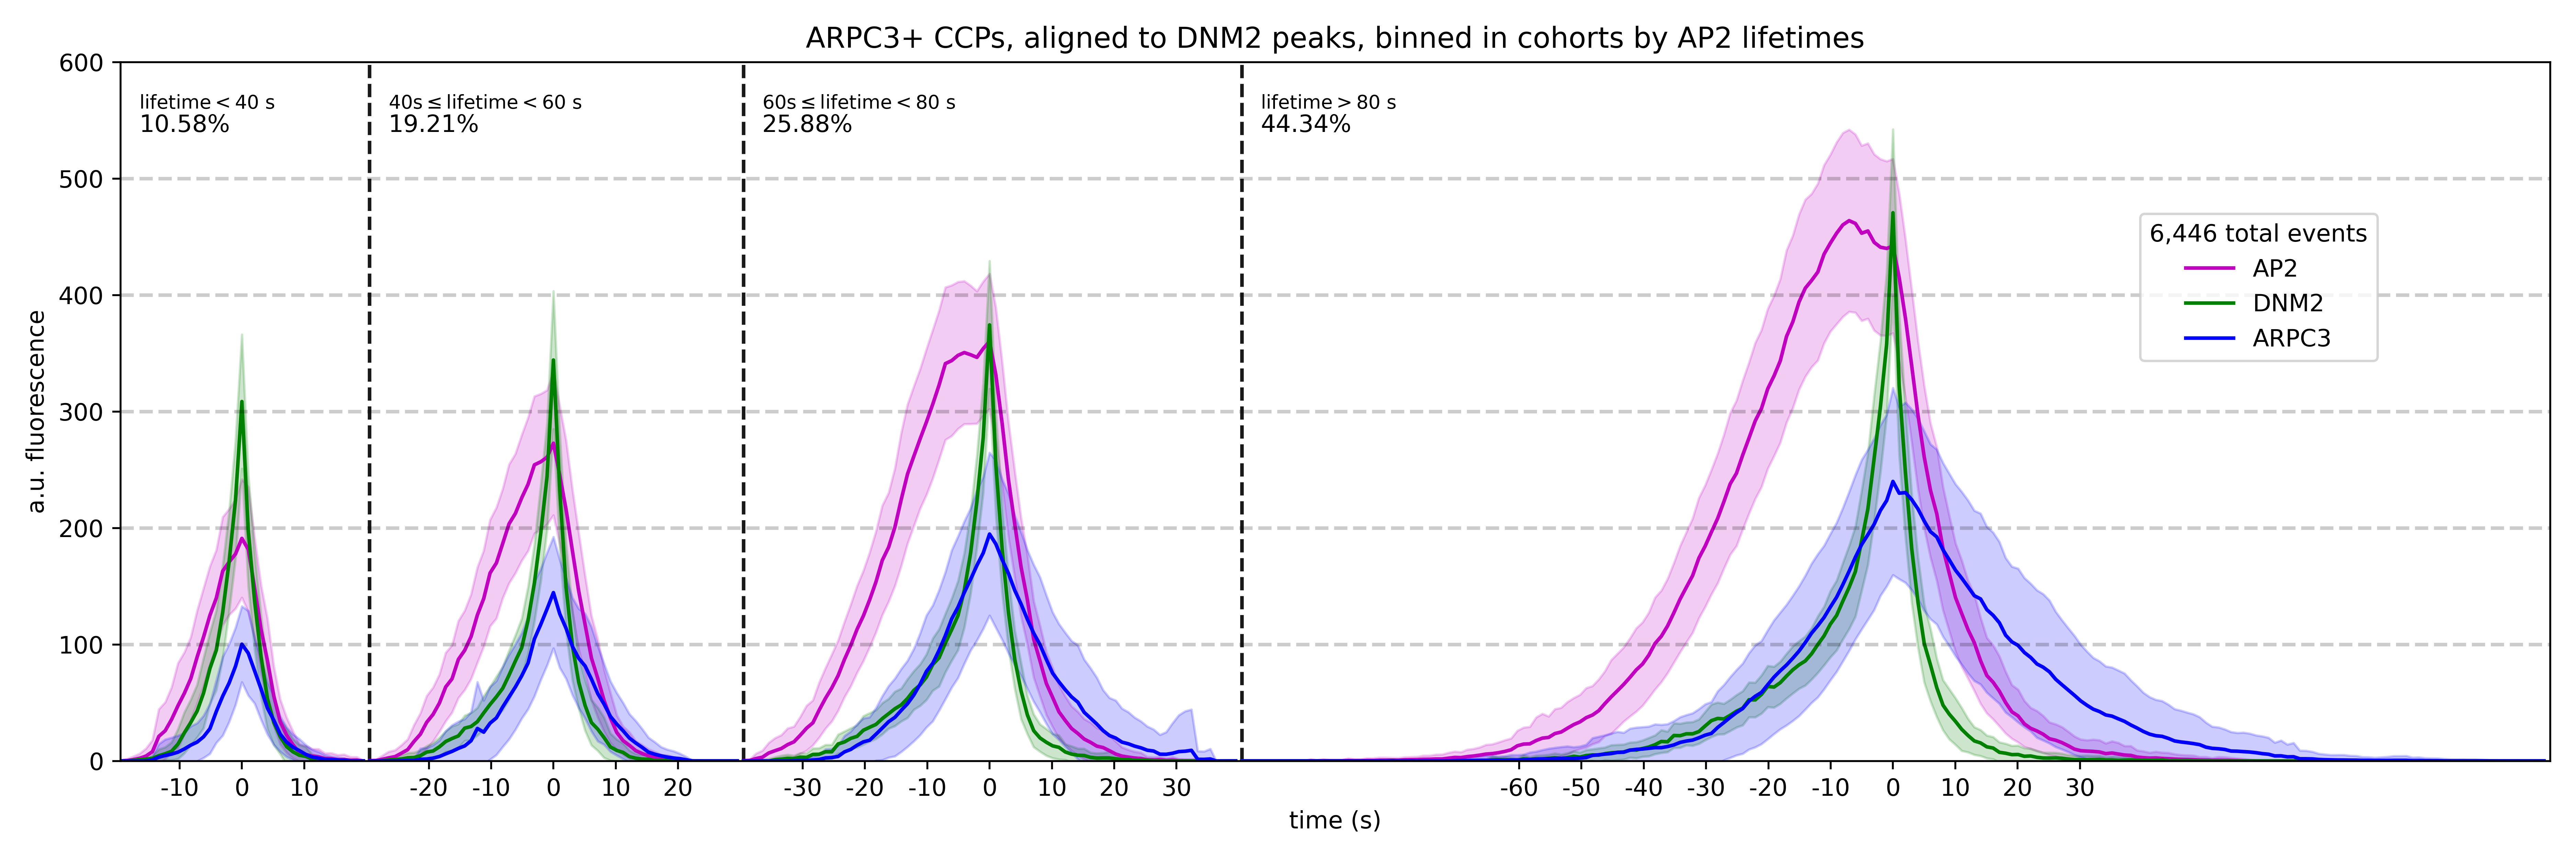

In [110]:
Image(filename=unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_arpc3plusccps_cohorts_centered_zero_zeropadding_sigatdnm2peakarpc3events_randomized.png', height=500, width=500)

In [111]:
%%capture

plt.style.use('default')

fig, axes = plt.subplots(1, 1, dpi=500, figsize=(15,5))
# axes_separation = axes.twinx()

cohorts = [[min(lifetime_arpc3_positive_nonsigdnm2peak),40],[40,60],[60,80],[80,max(lifetime_arpc3_positive_nonsigdnm2peak)]]

offsets, num_in_cohort, max_dnm2_cohort_indices = display_tracks.plot_separated_cohorts([axes], 
                                                                         channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak, 
                                                                         1, 
                                                                         cohorts, 
                                                                         [0, 1, 2], 
                                                                         [], 
                                                                         ['AP2', 'DNM2', 'ARPC3'],
                                                                         ['m', 'g', 'b'])

lines_0, labels_0 = axes.get_legend_handles_labels()
axes.legend(lines_0, labels_0, 
            loc='upper center', 
            bbox_to_anchor=(0.88, 0.8), 
            title="{:,}".format(len(channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak)) + ' total events')

y_lines = np.arange(0,600,100)

for i in range(1,len(y_lines)):
    
    axes.axhline(y_lines[i], 0, 1, linestyle='--', color='black', alpha=0.2)

text_horizontal_shifts = 3
text_percentage_y = 540
text_bounds_y = 560

for i in range(len(cohorts)):

    if i==0:
        axes.text(text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak)) + '%')
    elif i==len(cohorts)-1:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, '$\mathregular{lifetime >}$'+str(cohorts[i][0])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak)) + '%')
    else:
        axes.text(offsets[i]+text_horizontal_shifts, text_bounds_y, str(cohorts[i][0])+'$\mathregular{s \leq lifetime <}$'+str(cohorts[i][1])+' s', fontsize=8)
        axes.text(offsets[i]+text_horizontal_shifts, text_percentage_y, "{:.2f}".format(100*num_in_cohort[i]/len(channel_amplitudes_arpc3_positive_arpc3nonsigatdnm2peak)) + '%')
        
x_positions_ticks = []
x_labels_ticks = []
max_ticks_per_cohort = [[1, 1], [2, 2], [3, 3], [6, 3]]

for i in range(len(max_dnm2_cohort_indices)):
    

    num_ticks_before = np.min((int(np.floor((max_dnm2_cohort_indices[i])/10)),max_ticks_per_cohort[i][0]))
    num_ticks_after = np.min((int(np.ceil((cohorts[i][1]-max_dnm2_cohort_indices[i])/10)-1),max_ticks_per_cohort[i][1]))
    for j in range(num_ticks_before):
        
        x_labels_ticks.append(-10*(j+1))
        x_positions_ticks.append(-10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])
    
    x_labels_ticks.append(0)
    x_positions_ticks.append(offsets[i] + max_dnm2_cohort_indices[i])
    
    for j in range(num_ticks_after):
        
        x_labels_ticks.append(10*(j+1))
        x_positions_ticks.append(10*(j+1) + offsets[i] + max_dnm2_cohort_indices[i])


axes.set_xticks(0.5+np.array(x_positions_ticks), minor=False)
axes.set_xticklabels(x_labels_ticks, minor=False)


axes.set_xlabel('time (s)') 
axes.set_ylabel('a.u. fluorescence')
axes.set_title('ARPC3+ CCPs, aligned to DNM2 peaks, binned in cohorts by AP2 lifetimes')
axes.set_xlim([0,offsets[-1]+cohorts[-1][-1]])    
axes.set_ylim([0,600])  
# axes_separation.set_ylim([0,.3])
plt.tight_layout()   
plt.savefig(unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_arpc3plusccps_cohorts_centered_zero_zeropadding_nonsigatdnm2peakarpc3events_randomized.png')

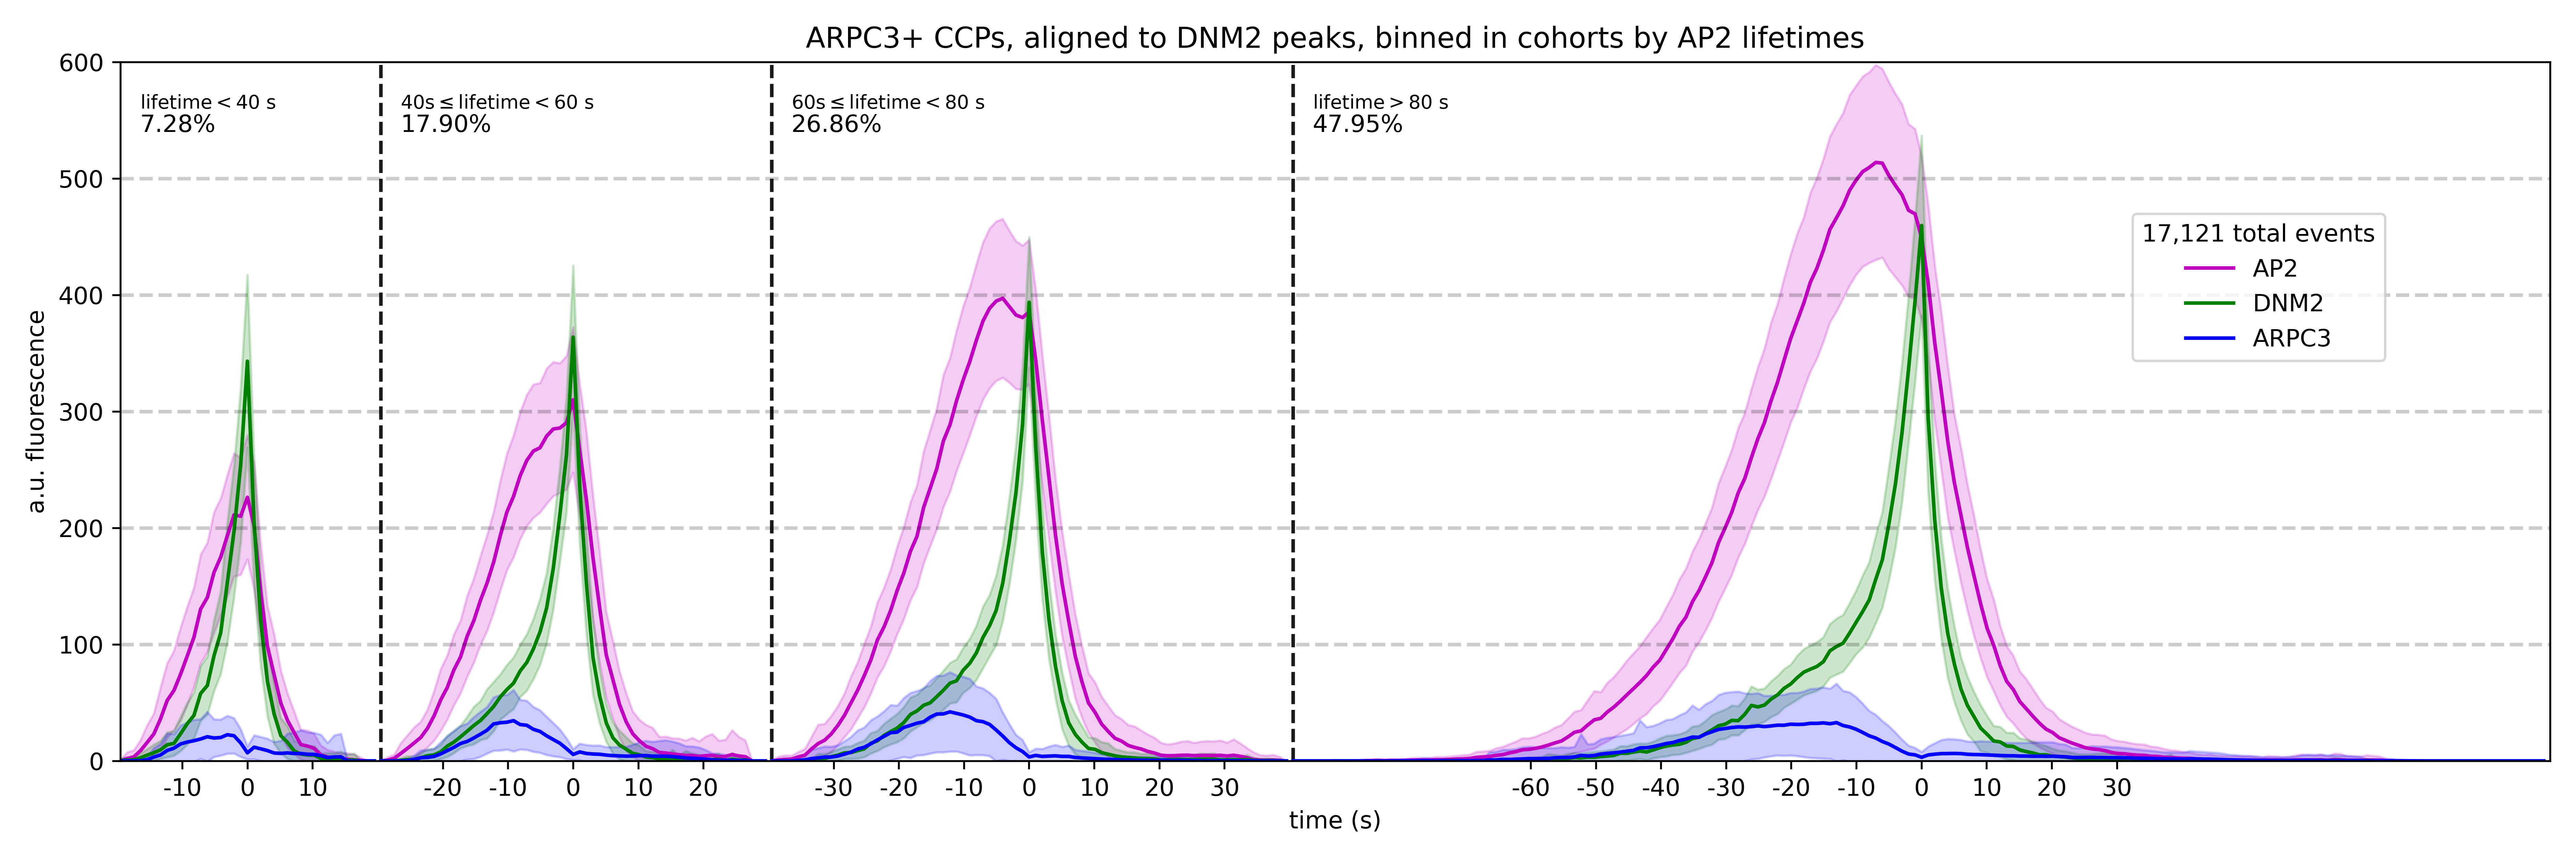

In [112]:
Image(filename=unique_user_saved_outputs+'/plots/all_overlaid_ap2dnm2_arpc3plusccps_cohorts_centered_zero_zeropadding_nonsigatdnm2peakarpc3events_randomized.png', height=500, width=500)

In [113]:
arpc3_lifetime_nonsig = np.array(merged_results['arpc3_lifetime_randomized'])[indices_arpc3nonsigatdnm2peak]
arpc3_lifetime_sig = np.array(merged_results['arpc3_lifetime_randomized'])[indices_arpc3sigatdnm2peak]

In [114]:
%%capture

plt.style.use('default')

plt.rcParams["figure.dpi"]=500
plt.rcParams["figure.figsize"]=(5,4)

plt.hist(arpc3_lifetime_sig,
         bins='auto',
         alpha=0.2,
         density=True,
         label='ARPC3 lifetime (randomized exp.)\nsignificant ARPC3 at DNM2 peak',
         color='blue')

plt.hist(arpc3_lifetime_nonsig,
         bins='auto',
         alpha=0.2,
         density=True,
         label='ARPC3 lifetime (randomized exp.)\nnonsignificant ARPC3 at DNM2 peak',
         color='green')

plt.legend(loc='upper right', framealpha=1)
plt.xlabel('time (s)')
plt.ylabel('frequency density')
plt.title('ARPC3+ events')
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/arpc3_lifetimes_randomized.png')

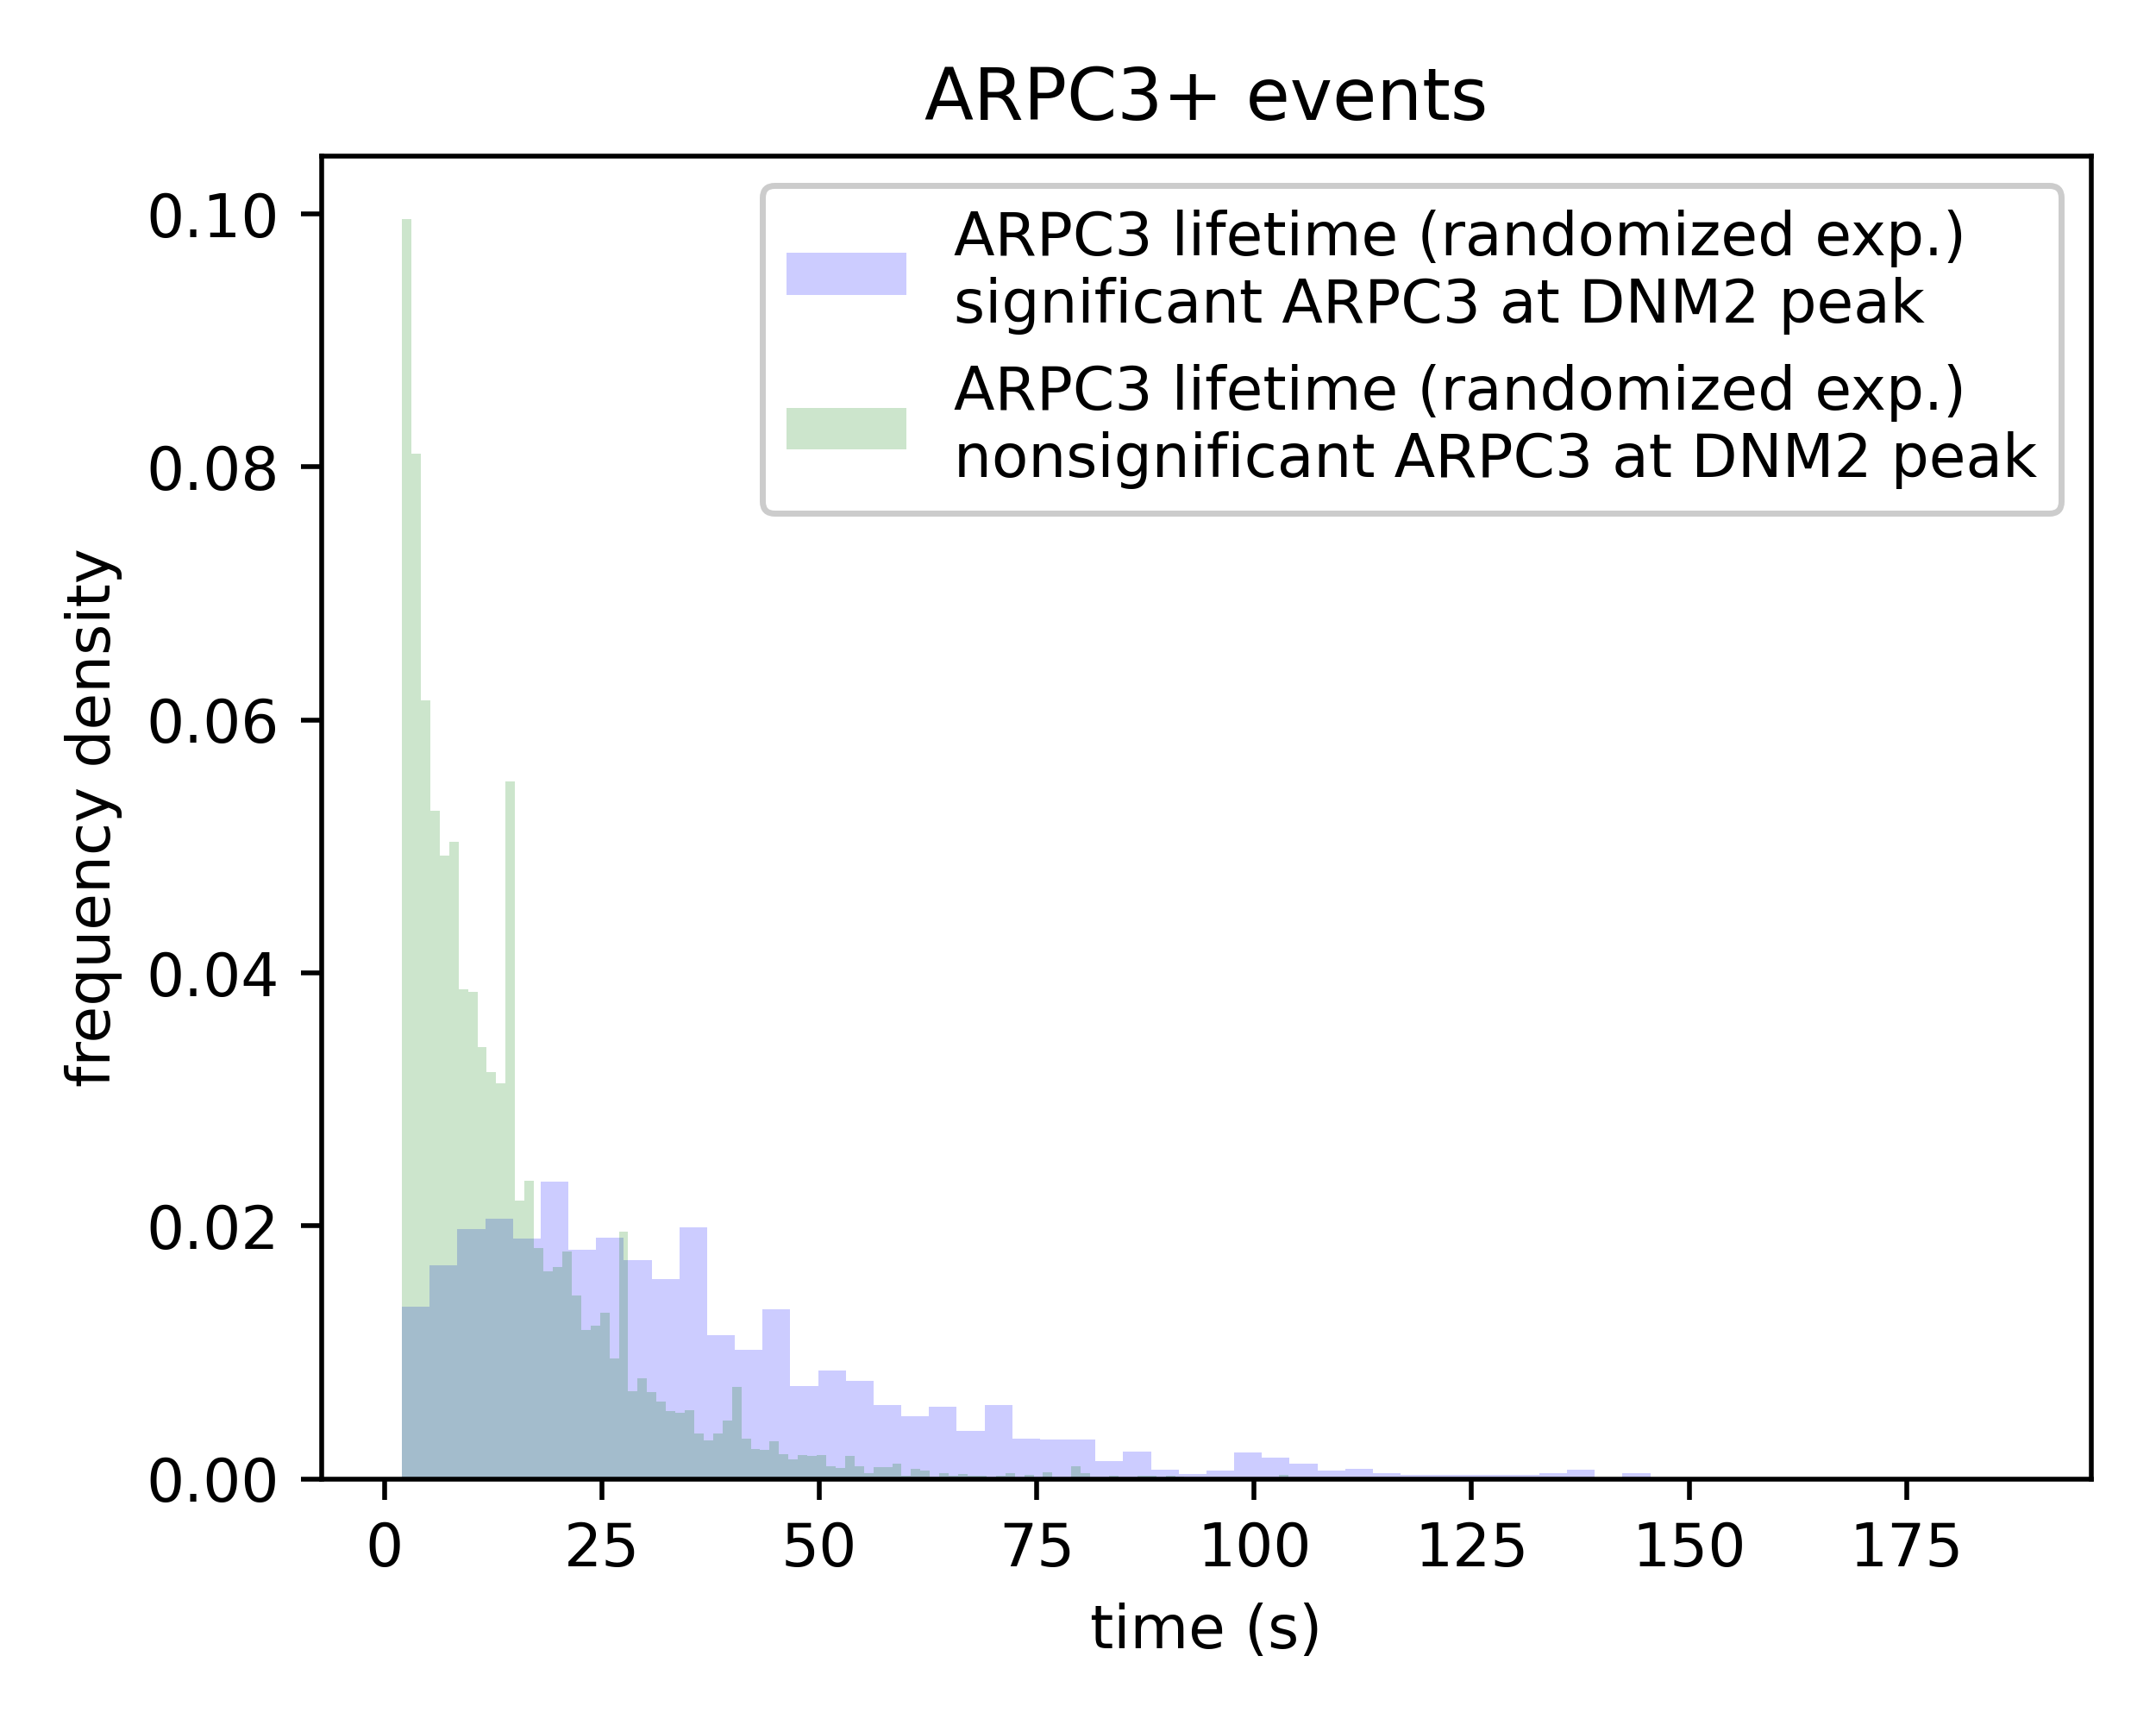

In [115]:
Image(filename=unique_user_saved_outputs+'/plots/arpc3_lifetimes_randomized.png', height=500, width=500)

In [116]:
%%capture

plt.style.use('default')

plt.figure(dpi=500)
for pair in experiment_combos:
    plt.scatter(pair[0], pair[1], color='b', alpha=0.2)
plt.xlabel('AP2 experiment #')
plt.ylabel('ARPC3 experiment #')
plt.savefig(unique_user_saved_outputs+'/plots/exp_pairs_randomized_arpc3association.png')

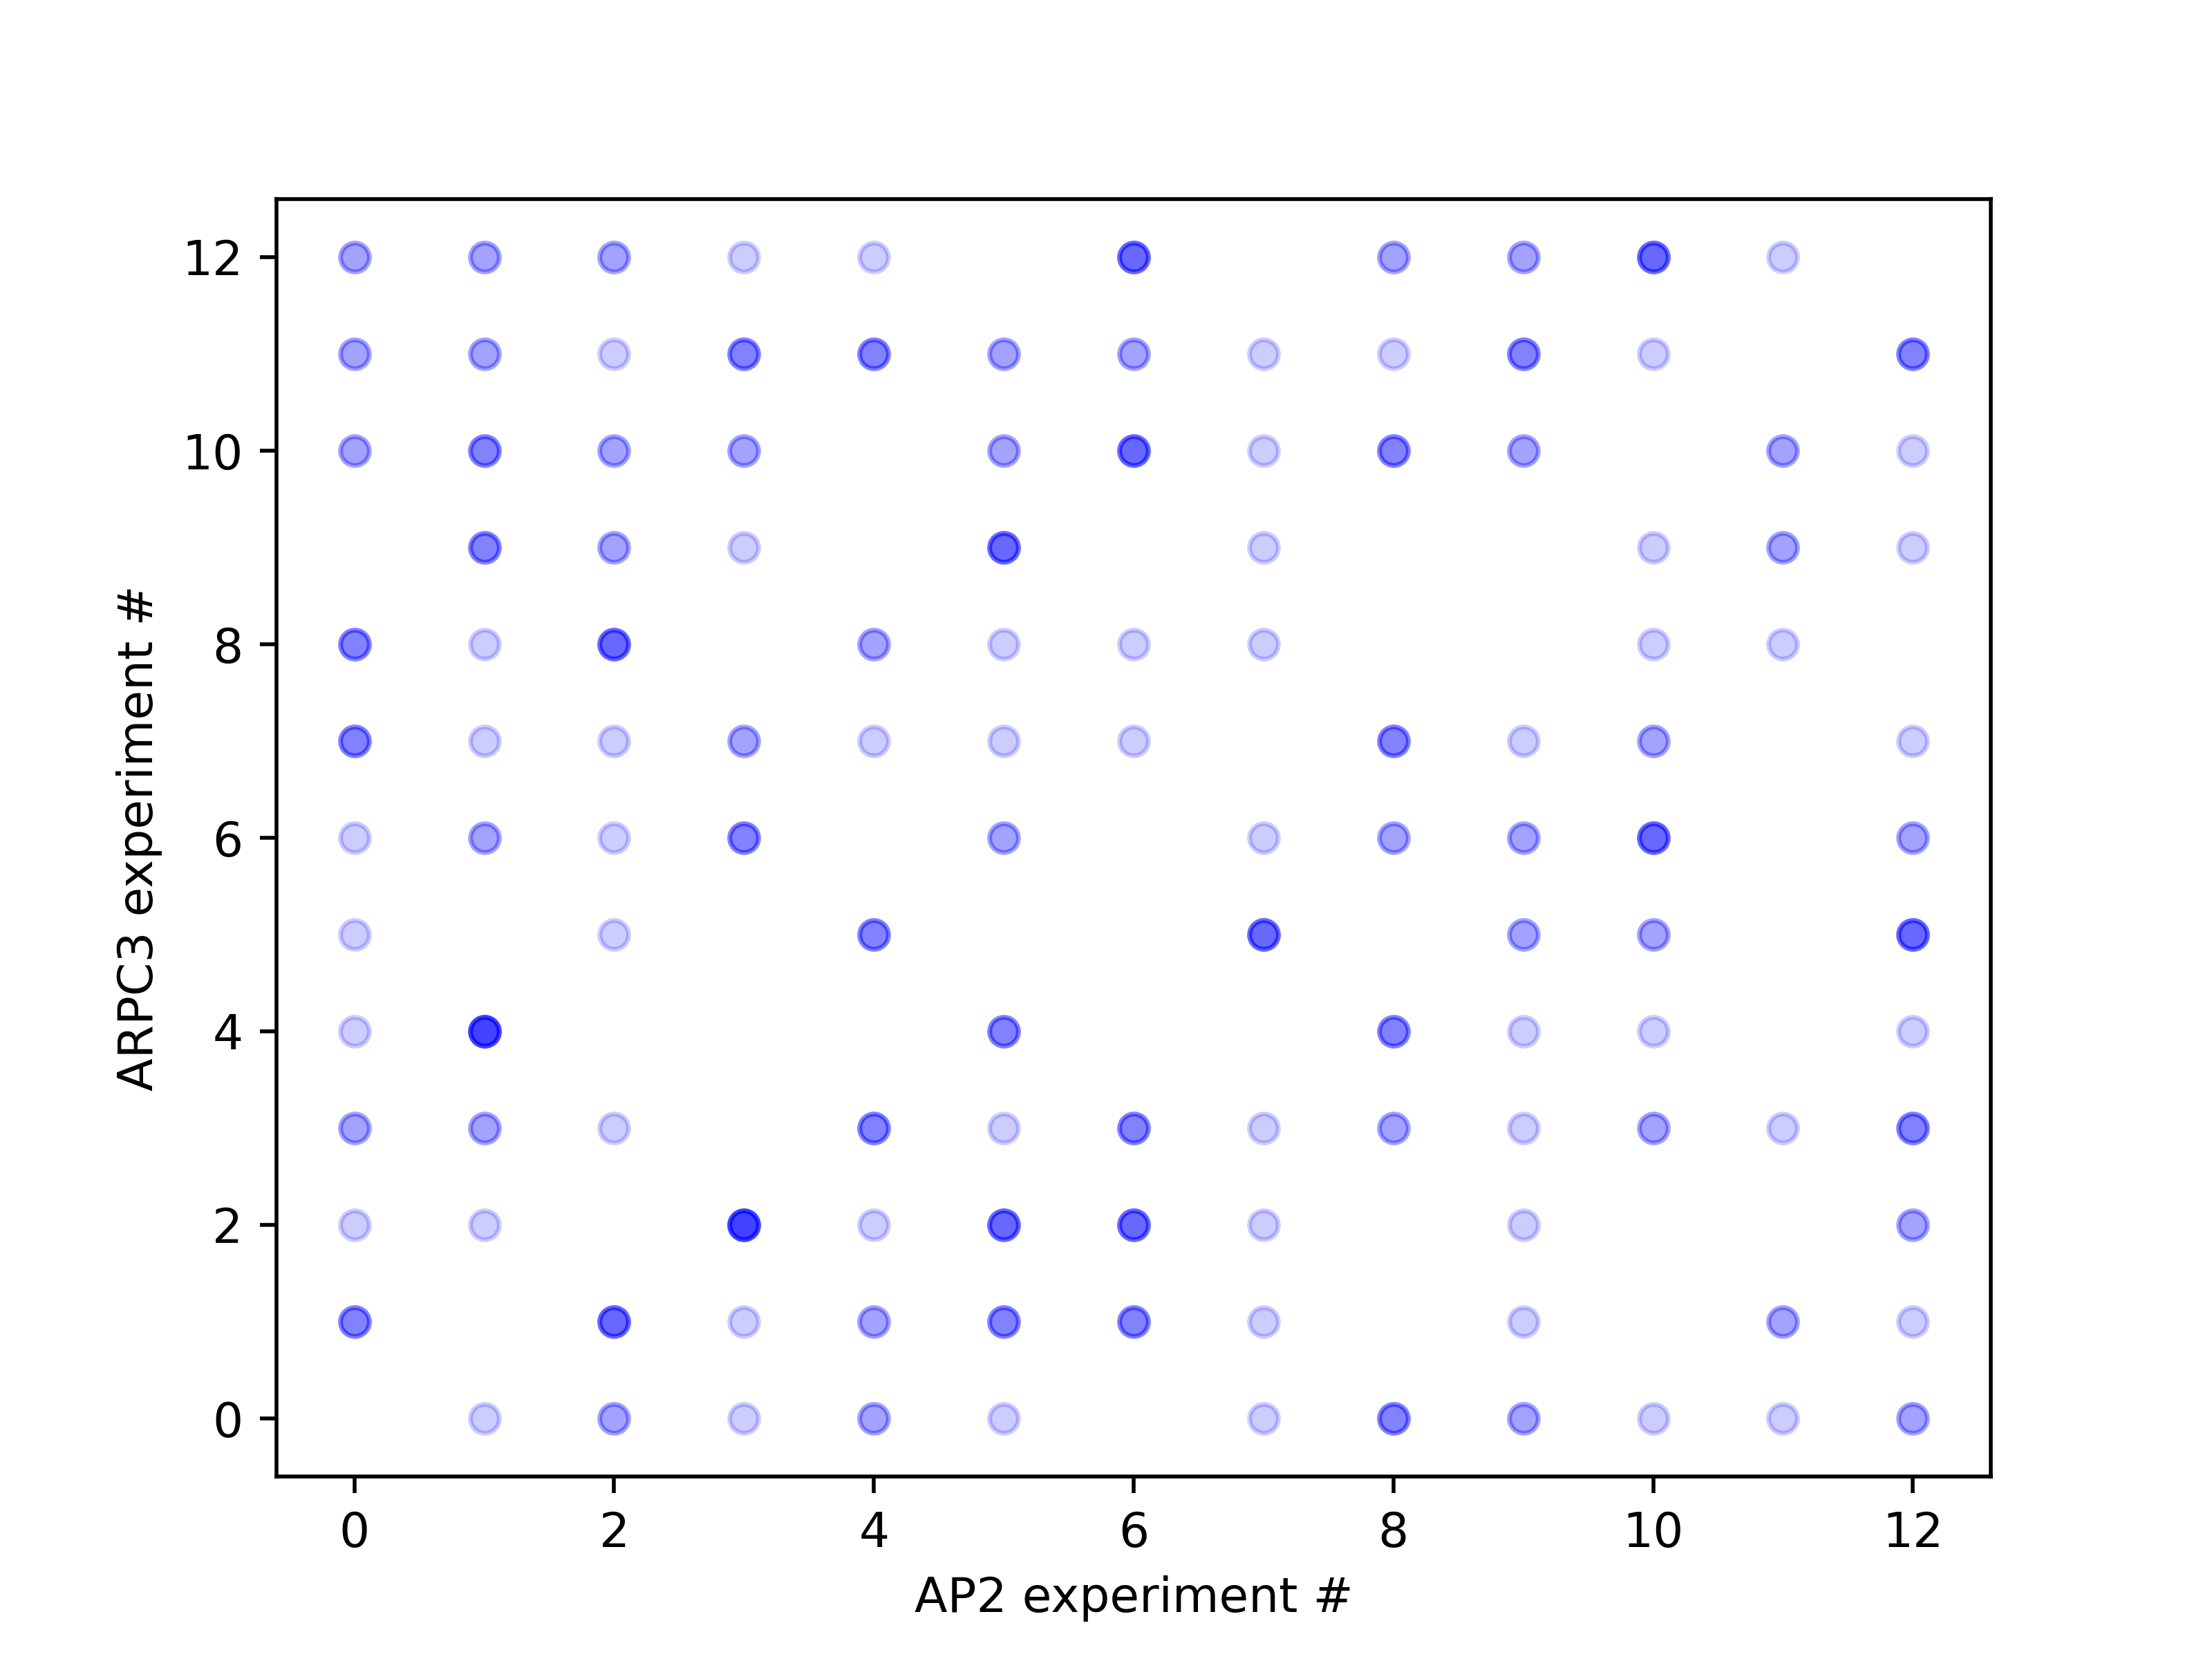

In [117]:
Image(filename=unique_user_saved_outputs+'/plots/exp_pairs_randomized_arpc3association.png', height=500, width=500)

In [118]:
with open(unique_user_saved_outputs+'/dataframes/merged_ap2arpc3_data_zeropadding', 'rb') as f:
    merged_results_true_model = pickle.load(f)  

In [119]:
fraction_arpc3_positive_true_model = merged_results_true_model['fraction_arpc3_positive']

fraction_arpc3_positive_mixed = merged_results_randomized['fraction_arpc3_positive_mixed']

In [120]:
%%capture
plt.figure(dpi=500)
plt.hist(fraction_arpc3_positive_mixed, color='blue', label='randomized', alpha=0.5, density=True, bins='doane')
plt.hist(fraction_arpc3_positive_true_model, color='orange', label='true', alpha=0.5, density=True, bins='doane')
plt.xlabel('fraction ARPC3+')
plt.legend()
plt.ylabel('frequency density')
plt.savefig(unique_user_saved_outputs+'/plots/fractionarpc3pos_true_random.png')

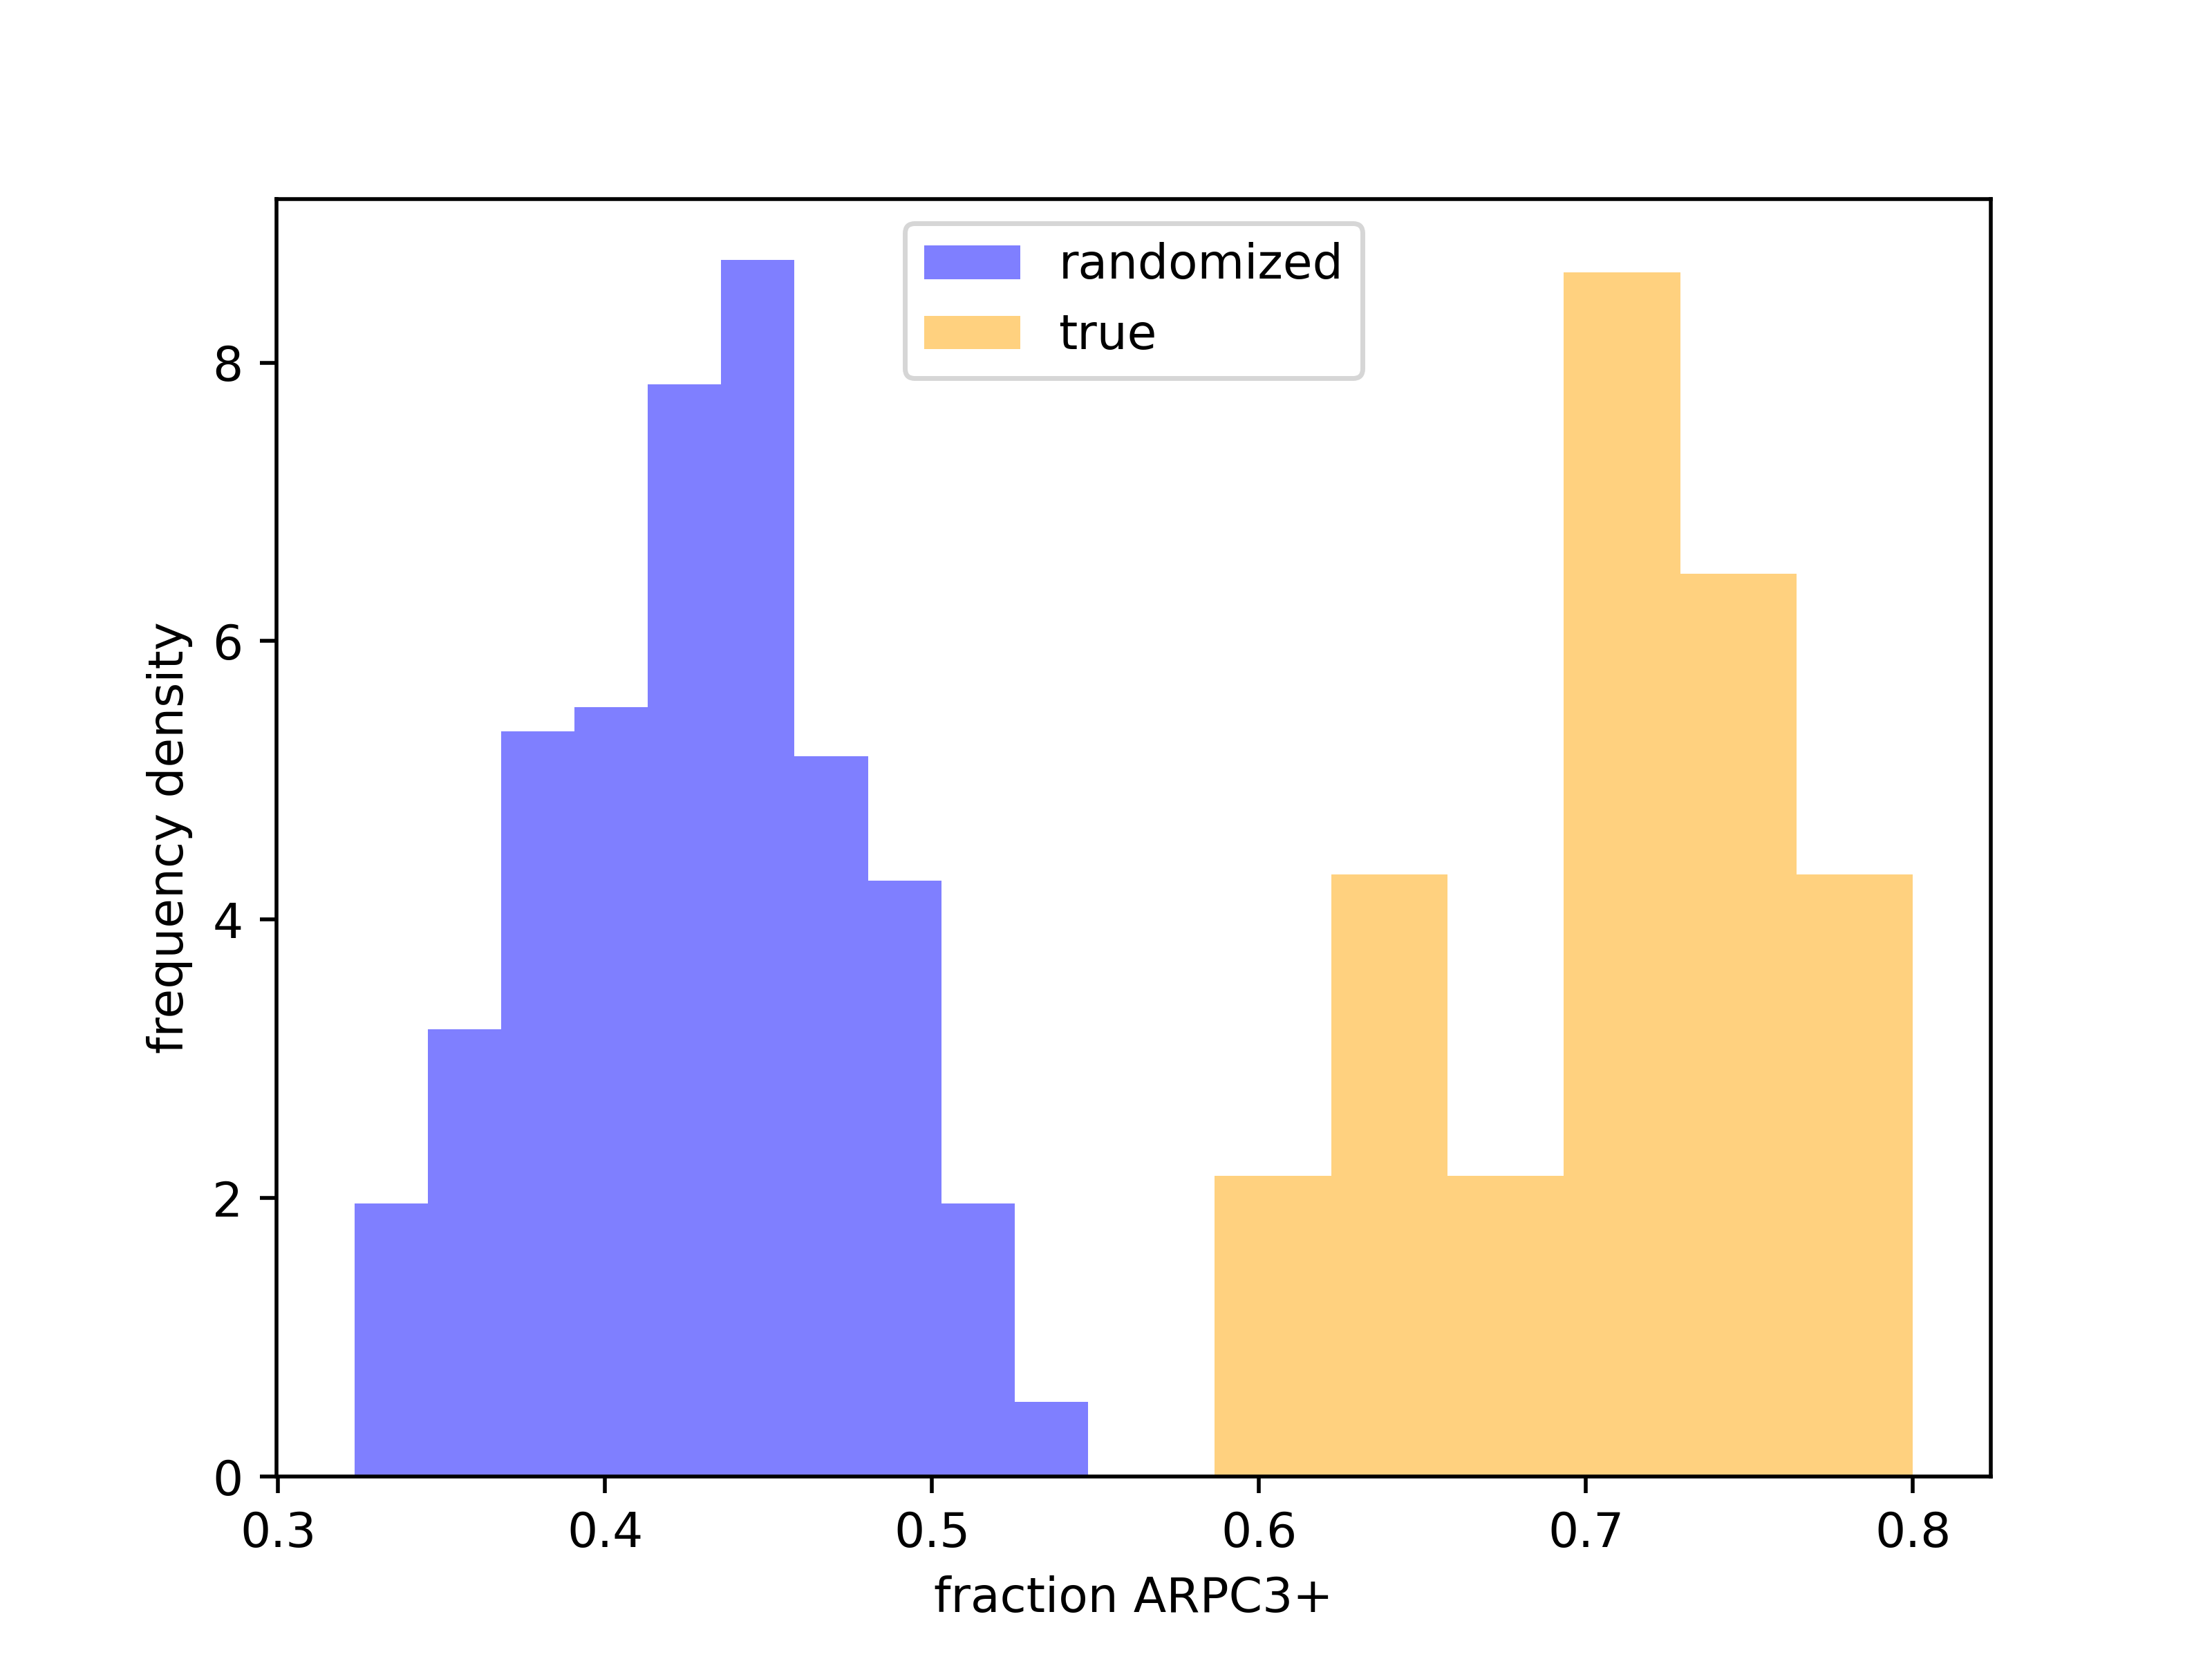

In [121]:
Image(filename=unique_user_saved_outputs+'/plots/fractionarpc3pos_true_random.png', height=500, width=500)

# upload hotspot predictions

In [122]:
significance_position_with_width = np.load(unique_user_saved_outputs+"/dataframes/significance_position_with_width_rayleigh_fit.npy")

with open(unique_user_saved_outputs+'/dataframes/peak_detections_with_widths', 'rb') as f:
    peak_detections_with_widths = pickle.load(f)

In [123]:
# 95th percentile of highest p-values for KS test of fit Rayleigh distribution to raw distribution
# in a specified peak-finding parameter combination
ks_pval_95th_percentile = np.percentile(significance_position_with_width, 95) 

In [124]:
# indices of pvals > 95th percentile
indices_above_threshold = np.nonzero(significance_position_with_width>ks_pval_95th_percentile)

In [125]:
len(indices_above_threshold[0])

86

In [126]:
distances_3 = np.arange(1,20,1) # minimum peak to peak distances
heights_3 = np.arange(50,300,25) # minimum peak heights
widths_3 = np.arange(1,10,1) # minimum peak widths

In [ ]:
sos = signal.butter(4, 0.2, 'lp', fs=1, output='sos') # low-pass 4-th order Butterworth filter

ccp_events_per_experiment_per_peakcondition = []
best_fit_peak_params_altmodel_grouped = []

for index in tqdm(zip(*indices_above_threshold)):

    distance = distances_3[index[0]]
    height = heights_3[index[1]]
    width = widths_3[index[2]]
#     print(distance, height, width)
    ccp_events_per_experiment_temp = [] # each entry is a list for each experiment of tracks corresponding to predicted ccps 
    best_fit_peak_params_altmodel_grouped.append([distance, height, width])
    for experiment_number in range(8, 21): # only look at 3-color movies
    
        current_exp_ind = np.where(experiment_number_track_candidates==experiment_number)[0] # all events in current experiment
        
        all_dnm2pos_events_exp = tracks_authentic_ccps_gmm[current_exp_ind]
#         print(len(all_dnm2pos_events_exp))
        all_dnm2_signal = []

        for i in range(len(all_dnm2pos_events_exp)): # stack all DNM2 intensities

            raw_dnm2_intensity = list(return_track_attributes.return_track_amplitude_no_buffer_channel(all_dnm2pos_events_exp,i,1))

            all_dnm2_signal.append(raw_dnm2_intensity)
            
        sos = signal.butter(4, 0.2, 'lp', fs=1, output='sos') # low-pass 4-th order Butterworth filter

        filtered_amplitudes = [] # filtered DNM2 traces per track of interest

        for i in range(len(all_dnm2_signal)):

            raw_intensity = all_dnm2_signal[i]
            # add zeros to end to account for phase shift of near-track-end peaks
            filtered_amplitudes.append(list(list(signal.sosfilt(sos, raw_intensity)) + [0, 0, 0, 0, 0])) 

        current_param_outputs = [] # one-hot encoding of indices of tracks with a single peak (0: multiple peaks)

#         print(len(filtered_amplitudes))
        for i in range(len(filtered_amplitudes)): # iterate through all filtered amplitudes

            pvals_dnm2 = return_track_attributes.return_pvals_detection_no_buffer(all_dnm2pos_events_exp, i, 1)
#             print('test')
#             print(len(np.where(np.array(pvals_dnm2)<0.01)[0]))
#             print(len(signal.find_peaks(filtered_amplitudes[i], 
#                          distance=distance, 
#                          height=height,
#                          width=width)[0]))
            # measure whether there is 1 peak with the specified peak-finding parameters
            if len(signal.find_peaks(filtered_amplitudes[i], 
                         distance=distance, 
                         height=height,
                         width=width)[0])==1 and len(np.where(np.array(pvals_dnm2)<0.01)[0])>0:
#                 print('test')
                current_param_outputs.append(1)

            else:

                current_param_outputs.append(0)    
                
#         print(current_param_outputs)    
#         print(len(np.where(np.array(current_param_outputs)==1)[0]))
        ccp_events_per_experiment_temp.append(np.array(all_dnm2pos_events_exp)[np.where(np.array(current_param_outputs)==1)[0]])
    
    ccp_events_per_experiment_per_peakcondition.append(ccp_events_per_experiment_temp)

29it [00:33,  1.07s/it]

In [ ]:
warnings.filterwarnings("ignore")
distance_query = 2 # pixel search radius for associating ap2 and arpc3 from separate tracking

fraction_arpc3_positive_alternativeccps = []
num_frames_associated_alternativeccps = []
ap2_arpc3_separation_average_arpc3_positive_alternativeccps = []
arpc3_lifetimes_alternativeccps = []
dnm2_arpc3_peak_time_difference_arpc3_positive_alternativeccps = []

for model_num, ccp_events_per_experiment_temp in tqdm(enumerate(ccp_events_per_experiment_per_peakcondition)):
    
    best_fit_peak_params_altmodel = best_fit_peak_params_altmodel_grouped[model_num]
    
    for experiment_number in range(8,21):  # iterate over all experiments

        num_with_mode = 0 # count number of events with and without arpc3
        num_without_mode = 0    
        num_no_neighbors=0
        ap2dmn2_tracks_in_experiment = ccp_events_per_experiment_temp[experiment_number-8] # filtered tracks
        arpc3_experiment=valid_tracks_arpc3[experiment_number-8] # cat 1 and 2 arpc3 events in experiment


        # select a tree for each frame containing all events in each frame
        kd_tree_arpc3_experiment, vals_tree = arpc3_trees[experiment_number-8]

        for track_num in range(len(ap2dmn2_tracks_in_experiment)): # iterate through all ap2 tracks in experiment


            frames_in_track_first_channel = list(return_track_attributes.return_frames_in_track_no_buffer(ap2dmn2_tracks_in_experiment, track_num)-1) # frames of ap2 and dnm2
            ch0_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # positions of ap2 and dnm2
            ch0_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 0)
            ch1_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
            ch1_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
            ap2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 0) # ap2 and dnm2 intensities
            dnm2_int = return_track_attributes.return_track_amplitude_no_buffer_channel(ap2dmn2_tracks_in_experiment, track_num, 1)
            filtered_dnm2_signal = list(list(signal.sosfilt(sos, dnm2_int)) + [0, 0, 0, 0, 0])

            dnm2_peak = signal.find_peaks(filtered_dnm2_signal, 
                                          distance=best_fit_peak_params_altmodel[0], 
                                          height=best_fit_peak_params_altmodel[1],
                                          width=best_fit_peak_params_altmodel[2])[0][0]
        
            frame_dnm2_peak = frames_in_track_first_channel[dnm2_peak] # the movie frame (indexed starting from 0) that dnm2 peaks
            candidate_arpc3_neighbors = [] # indices of arpc3 events that take place near ap2
            no_neighbors=True # no neighbors found yet

            # search for candidate arpc3 neighbors in each ap2 track's frame
            for frame in frames_in_track_first_channel:

                frame_ch0 = frames_in_track_first_channel.index(frame)
                # frame's tree
                current_tree = kd_tree_arpc3_experiment[frame]

                # ap2 fitted position at current frame
                current_ap2_position = np.array([ch0_x[frame_ch0], ch0_y[frame_ch0]]).reshape(1, -1)

                # indices of arpc3 events within the query radius
                ind = current_tree.query_radius(current_ap2_position,
                                                r=distance_query)

                if len(ind[0])>0:
                    no_neighbors = False # if there is a neighbor

                # check if each arpc3 neighbor originated before or after the ap2 event
                for candidate in ind[0]:

                    candidate_index = int(vals_tree[frame][candidate][0]) # get the index of the arpc3 event

                    frames_in_track_candidate_neighbor = list(return_track_attributes.return_frames_in_track_no_buffer(arpc3_experiment, candidate_index)-1)

                    # consider the arpc3 event if it originated after the ap2 event and before the dnm2 peak
                    if frames_in_track_candidate_neighbor[0]>frames_in_track_first_channel[0] and frames_in_track_candidate_neighbor[0]<frame_dnm2_peak:

                        candidate_arpc3_neighbors.append(candidate_index)


            if no_neighbors==True: # if there are absolutely no neighbors present, the CCP is arpc3 negative

                num_no_neighbors+=1

            # get mode(s) of candidates
            mode=stats.mode(candidate_arpc3_neighbors)

            # if there is a unique candidate:
            if mode[0].size == 1:

                num_frames_associated_alternativeccps.append(mode[1][0])

                num_with_mode+=1 # count this track as arpc3 positive            

                associated_track_second_channel = mode[0][0] # index of arpc3 track associated with current ap2 track

                frames_in_track_second_channel = list(return_track_attributes.return_frames_in_track_no_buffer(arpc3_experiment, associated_track_second_channel)-1) # frames of arpc3 track

                frames_intersection = list(set(frames_in_track_first_channel) & set(frames_in_track_second_channel)) # find all frames ap2 and arpc3 overlap during movie
                frames_intersection.sort() # sort the frames in ascending order

                # amplitudes of all channels
                ch0_amplitudes = ap2_int # ap2, dnm2, arpc3 intensities
                ch1_amplitudes = dnm2_int
                ch2_amplitudes = return_track_attributes.return_track_amplitude_no_buffer_channel(arpc3_experiment, associated_track_second_channel, 0)

                arpc3_lifetimes_alternativeccps.append(len(ch2_amplitudes))
                
                # position of arpc3
                ch2_x = return_track_attributes.return_puncta_x_position_no_buffer_one_channel(arpc3_experiment, associated_track_second_channel, 0)
                ch2_y = return_track_attributes.return_puncta_y_position_no_buffer_one_channel(arpc3_experiment, associated_track_second_channel, 0)

                # correct intensities and positions for missing frames where ap2 and arpc3 are non-overlapping
                new_ch0_vector = []
                new_ch1_vector = []
                new_ch2_vector = []
                new_ch0_x = []
                new_ch0_y = []
                new_ch1_x = []
                new_ch1_y = []
                new_ch2_x = []
                new_ch2_y = []

                # first/last frame either ap2 or arpc3 shows up
                min_frame = np.nanmin([np.nanmin(frames_in_track_first_channel),np.nanmin(frames_in_track_second_channel)]) #nan to account for gaps
                max_frame = np.nanmax([np.nanmax(frames_in_track_first_channel),np.nanmax(frames_in_track_second_channel)])

                # all frames shared between ap2 and arpc3
                frames_all = [i for i in range(int(min_frame),int(max_frame)+1)]

                channel_0_2_separation_track = [] # ap2 and arpc3 separation
                channel_0_2_angle_track = [] # ap2 and arpc3 angle 
                channel_0_1_separation_track = [] # ap2 and dnm2 separation
                channel_1_2_separation_track = []

                for frame in frames_all: # iterate over all frames

                    # if frames of ap2 and arpc3 are non-overlapping, do not measure their separation
                    if (frame in frames_in_track_first_channel and frame not in frames_in_track_second_channel) or (frame in frames_in_track_second_channel and frame not in frames_in_track_first_channel):
                        channel_0_2_separation_track.append(0)
                        channel_0_2_angle_track.append(0)
                        channel_1_2_separation_track.append(0)
                    # if only ap2 is present
                    if frame in frames_in_track_first_channel and frame not in frames_in_track_second_channel:

                        channel_0_index = frames_in_track_first_channel.index(frame) # get relative index of ap2 in this frame 

                        new_ch0_vector.append(ch0_amplitudes[channel_0_index]) # add ap2 and dnm2 amplitudes
                        new_ch1_vector.append(ch1_amplitudes[channel_0_index]) 
                        new_ch0_x.append(ch0_x[channel_0_index]) # ap2 and dnm2 positions
                        new_ch0_y.append(ch0_y[channel_0_index])
                        new_ch1_x.append(ch1_x[channel_0_index])
                        new_ch1_y.append(ch1_y[channel_0_index])

                        new_ch2_vector.append(0) # no arpc3
                        new_ch2_x.append(0) # arpc3 position off grid
                        new_ch2_y.append(0)
                        pval_arpc3_detection.append(np.NaN)

                        channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch1_x[channel_0_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch1_y[channel_0_index]))**2)) # ap2-dnm2 separation

                    # if only arpc3 is present
                    elif frame in frames_in_track_second_channel and frame not in frames_in_track_first_channel: 

                        channel_2_index = frames_in_track_second_channel.index(frame) # get relative index of arpc3 in this frame 

                        new_ch2_vector.append(ch2_amplitudes[channel_2_index]) # add arpc3 amplitudes and positions
                        new_ch2_x.append(ch2_x[channel_2_index]) 
                        new_ch2_y.append(ch2_y[channel_2_index])

                        new_ch0_vector.append(0) # no ap2 or dnm2
                        new_ch1_vector.append(0)    
                        new_ch0_x.append(0) # ap2 and dnm2 position off grid
                        new_ch0_y.append(0)
                        new_ch1_x.append(0)
                        new_ch1_y.append(0)

                        channel_0_1_separation_track.append(0) # no separation between ap2 and dnm2 

                        pval_arpc3_detection.append(return_track_attributes.return_pvals_detection_no_buffer(arpc3_experiment, associated_track_second_channel, 0)[channel_2_index])

                    # if both ap2 and arpc3 in frame
                    elif frame in frames_in_track_first_channel and frame in frames_in_track_second_channel:  

                        channel_0_index = frames_in_track_first_channel.index(frame) # get relative indices
                        channel_2_index = frames_in_track_second_channel.index(frame)

                        new_ch0_vector.append(ch0_amplitudes[channel_0_index]) # add amplitudes and positionsfor all channels
                        new_ch1_vector.append(ch1_amplitudes[channel_0_index])
                        new_ch2_vector.append(ch2_amplitudes[channel_2_index])
                        new_ch0_x.append(ch0_x[channel_0_index]) # ap2 and dnm2 positions
                        new_ch0_y.append(ch0_y[channel_0_index])
                        new_ch1_x.append(ch1_x[channel_0_index])
                        new_ch1_y.append(ch1_y[channel_0_index])
                        new_ch2_x.append(ch2_x[channel_2_index]) 
                        new_ch2_y.append(ch2_y[channel_2_index])

                        channel_0_1_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch1_x[channel_0_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch1_y[channel_0_index]))**2)) # ap2-dnm2 separation

                        # ap2 and arpc3 separation
                        channel_0_2_separation_track.append(np.sqrt((0.108*(ch0_x[channel_0_index]-ch2_x[channel_2_index]))**2 + (0.108*(ch0_y[channel_0_index]-ch2_y[channel_2_index]))**2))
    #                     channel_0_2_angle_track.append(angle_between((0,0),((ch0_x[channel_0_index]-ch2_x[channel_2_index]),(ch0_y[channel_0_index]-ch2_y[channel_2_index]))))              
                        channel_1_2_separation_track.append(np.sqrt((0.108*(ch1_x[channel_0_index]-ch2_x[channel_2_index]))**2 + (0.108*(ch1_y[channel_0_index]-ch2_y[channel_2_index]))**2))

                        pval_arpc3_detection.append(return_track_attributes.return_pvals_detection_no_buffer(arpc3_experiment,associated_track_second_channel,0)[channel_2_index])

                ap2_arpc3_separation_average_arpc3_positive_alternativeccps.append(np.nanmean(channel_0_2_separation_track))
                dnm2_arpc3_peak_time_difference_arpc3_positive_alternativeccps.append(np.nanargmax(ch1_amplitudes)-np.nanargmax(ch2_amplitudes))

            elif no_neighbors==True: # if there is no mode then the event is arpc3 negative

                num_without_mode += 1 

        fraction_arpc3_positive_alternativeccps.append(num_with_mode/(num_with_mode+num_without_mode))   

In [130]:
best_fit_peak_params

array([ 17, 125,   5])

In [ ]:
len(fraction_arpc3_positive_alternativeccps)

In [ ]:
np.save(unique_user_saved_outputs+'/dataframes/fraction_arpc3_positive_alternativeccpmodels', fraction_arpc3_positive_alternativeccps)
np.save(unique_user_saved_outputs+'/dataframes/num_frames_associated_alternativeccpmodels', num_frames_associated_alternativeccps)
np.save(unique_user_saved_outputs+'/dataframes/avg_ap2arpc3_sep_alternativeccpmodels', ap2_arpc3_separation_average_arpc3_positive_alternativeccps)
np.save(unique_user_saved_outputs+'/dataframes/arpc3_lifetimes_alternativeccpmodels', arpc3_lifetimes_alternativeccps)
np.save(unique_user_saved_outputs+'/dataframes/dnm2_arpc3_peak_time_difference_arpc3_positive_alternativeccps', dnm2_arpc3_peak_time_difference_arpc3_positive_alternativeccps)

In [ ]:
fraction_arpc3_positive_alternativeccpmodels = np.load(unique_user_saved_outputs+'/dataframes/fraction_arpc3_positive_alternativeccpmodels.npy')


In [ ]:
fraction_arpc3_positive_alternativeccpmodels_array = fraction_arpc3_positive_alternativeccpmodels.reshape((len(ccp_events_per_experiment_per_peakcondition), len(valid_tracks_arpc3)))
mean_fraction_arpc3_positive_alternativeccpmodels = np.mean(fraction_arpc3_positive_alternativeccpmodels_array, axis=1)
std_fraction_arpc3_positive_alternativeccpmodels = np.std(fraction_arpc3_positive_alternativeccpmodels_array, axis=1)

In [ ]:
%%capture
plt.figure(dpi=500)
plt.scatter(mean_fraction_arpc3_positive_alternativeccpmodels, std_fraction_arpc3_positive_alternativeccpmodels, alpha=0.2)
plt.xlim([0,1])
plt.xlabel('mean (between FOVs) of fraction of ARPC3+ CCPs')
plt.ylabel('std (between FOVs)')
plt.title('competing models for CCP selection')
plt.savefig(unique_user_saved_outputs+'/plots/fractionarpc3pos_and_std_competingccpmodels.png', bbox_inches='tight')

In [ ]:
Image(filename=unique_user_saved_outputs+'/plots/fractionarpc3pos_and_std_competingccpmodels.png', height=500, width=500)

In [ ]:
with open(unique_user_saved_outputs+'/dataframes/merged_ap2arpc3_data_zeropadding', 'rb') as f:
    merged_results_truemodel = pickle.load(f) 
fraction_arpc3_positive = merged_results_truemodel['fraction_arpc3_positive']
num_frames_associated_randomized = merged_results_randomized['num_frames_associated_randomized']
ap2_arpc3_separation_average_arpc3_positive_randomized = merged_results_randomized['ap2_arpc3_separation_average_arpc3_positive_randomized']
num_frames_associated_arpc3_positive = merged_results_true_model['num_frames_associated_arpc3_positive']
ap2_arpc3_separation_average_arpc3_positive = merged_results_true_model['ap2_arpc3_separation_average_arpc3_positive']
significant_arpc3_at_dnm2_peak_arpc3_positive = merged_results_true_model['significant_arpc3_at_dnm2_peak_arpc3_positive']

In [ ]:
%%capture
plt.figure(dpi=500)
plt.hist(fraction_arpc3_positive_mixed, color='blue', label='randomized', alpha=0.5, density=True, bins='auto')
plt.hist(fraction_arpc3_positive_alternativeccpmodels, color='green', label='alternative CCP models', alpha=0.5, density=True, bins='auto')
plt.hist(fraction_arpc3_positive, color='orange', label='model used', alpha=0.5, density=True, bins='auto')
plt.xlabel('fraction ARPC3+')
plt.legend()
plt.ylabel('frequency density')
plt.savefig(unique_user_saved_outputs+'/plots/fractionarpc3pos_true_altccp_random.png')

In [ ]:
Image(filename=unique_user_saved_outputs+'/plots/fractionarpc3pos_true_altccp_random.png', height=500, width=500)

In [ ]:
num_frames_associated_alternativeccps = np.load(unique_user_saved_outputs+'/dataframes/num_frames_associated_alternativeccpmodels.npy')
ap2_arpc3_separation_average_arpc3_positive_alternativeccps = np.load(unique_user_saved_outputs+'/dataframes/avg_ap2arpc3_sep_alternativeccpmodels.npy')

In [ ]:
%%capture
fig, axes = plt.subplots(3,1, dpi=500, figsize=(3,5))
axes[0].hist2d(num_frames_associated_randomized, ap2_arpc3_separation_average_arpc3_positive_randomized, cmap='Purples', bins=100, alpha=1, label='randomized experiments');
axes[0].set_xlim(0,50)
axes[0].set_ylim(0,0.5)
axes[1].hist2d(num_frames_associated_arpc3_positive, ap2_arpc3_separation_average_arpc3_positive, cmap='Greens', bins=100, alpha=0.2, label='selected model');
axes[1].set_xlim(0,50)
axes[1].set_ylim(0,0.5)
axes[2].hist2d(num_frames_associated_alternativeccps, ap2_arpc3_separation_average_arpc3_positive_alternativeccps, cmap='Reds', bins=100, alpha=0.2, label='alternative CCP models');
axes[2].set_xlim(0,50)
axes[2].set_ylim(0,0.5)
axes[2].set_xlabel('number of frames AP2 \nis associated with ARPC3')
fig.text(-0.05, 0.5, 'mean separation between AP2 \nand ARPC3 for paired event', va='center', rotation='vertical')
axes[0].set_title('randomized experiment pairs')
axes[1].set_title('selected model')
axes[2].set_title('alternative CCP models')
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/numframesvsmeansep_randomtruealtccp.png')

In [ ]:
Image(filename=unique_user_saved_outputs+'/plots/numframesvsmeansep_randomtruealtccp.png', height=500, width=500)

In [ ]:
%%capture
fig, axes = plt.subplots(2,1, dpi=500, figsize=(5,6))
axes[0].scatter(num_frames_associated_randomized, 
                ap2_arpc3_separation_average_arpc3_positive_randomized, 
                cmap='bwr', 
                alpha=0.01, 
                label='randomized experiments',
                c=significant_arpc3_at_dnm2_peak_arpc3_positive_randomized);

axes[0].set_xlim(0,50)
axes[0].set_ylim(0,0.5)
axes[1].scatter(num_frames_associated_arpc3_positive, 
                ap2_arpc3_separation_average_arpc3_positive, 
                cmap='bwr',
                alpha=0.1, 
                label='selected model',
                c=significant_arpc3_at_dnm2_peak_arpc3_positive);
axes[1].set_xlim(0,50)
axes[1].set_ylim(0,0.5)


axes[1].set_xlabel('number of frames AP2 is associated with ARPC3')
fig.text(-0.10, 0.5, 'mean separation between AP2 \nand ARPC3 for paired event', va='center', rotation='vertical')
axes[0].set_title('randomized experiment pairs')
axes[1].set_title('selected model')
plt.tight_layout()
plt.savefig(unique_user_saved_outputs+'/plots/numframesvsmeansep_randomtruealtccp_colorizedbyarpsigatdnm2peakoverlaid.png', bbox_inches='tight')

In [ ]:
Image(filename=unique_user_saved_outputs+'/plots/numframesvsmeansep_randomtruealtccp_colorizedbyarpsigatdnm2peakoverlaid.png', height=500, width=500)

In [ ]:
%%capture
fig, axes = plt.subplots(2,2, dpi=500, figsize=(6,6))
axes[0,0].scatter(np.array(num_frames_associated_randomized)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive_randomized)==0)], 
                np.array(ap2_arpc3_separation_average_arpc3_positive_randomized)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive_randomized)==0)], 
                c='b', 
                alpha=0.01)

axes[0,0].set_xlim(0,50)
axes[0,0].set_ylim(0,0.5)
axes[0,0].set_title('randomized, non-significant')
axes[0,1].scatter(np.array(num_frames_associated_randomized)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive_randomized)==1)], 
                np.array(ap2_arpc3_separation_average_arpc3_positive_randomized)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive_randomized)==1)], 
                c='r',
                alpha=0.01)

axes[0,1].set_xlim(0,50)
axes[0,1].set_ylim(0,0.5)
axes[0,1].set_title('randomized, significant')
axes[1,0].scatter(np.array(num_frames_associated_arpc3_positive)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive)==0)], 
                np.array(ap2_arpc3_separation_average_arpc3_positive)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive)==0)], 
                c='b', 
                alpha=0.1)

axes[1,0].set_xlim(0,50)
axes[1,0].set_ylim(0,0.5)
axes[1,0].set_title('true, non-significant')
axes[1,1].scatter(np.array(num_frames_associated_arpc3_positive)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive)==1)], 
                np.array(ap2_arpc3_separation_average_arpc3_positive)[np.where(np.array(significant_arpc3_at_dnm2_peak_arpc3_positive)==1)], 
                c='r',
                alpha=0.1)

axes[1,1].set_xlim(0,50)
axes[1,1].set_ylim(0,0.5)
axes[1,1].set_title('true, significant')
plt.tight_layout()
fig.text(-0.05, 0.5, 'mean separation between AP2 \nand ARPC3 for paired event', va='center', rotation='vertical')
fig.text(0.25, -0.01, 'number of frames AP2 is associated with ARPC3', va='center')
plt.savefig(unique_user_saved_outputs+'/plots/numframesvsmeansep_randomtruealtccp_colorizedbyarpsigatdnm2peaksplitapart.png', bbox_inches='tight')

In [ ]:
Image(filename=unique_user_saved_outputs+'/plots/numframesvsmeansep_randomtruealtccp_colorizedbyarpsigatdnm2peaksplitapart.png', height=500, width=500)